# What Makes a Hit?
# Predicting the Popularity of a Songs on Spotify

### Presented by Malachi Hale

## Executive Summary
### Background

Spotify is the world's largest music and audio streaming service provider. Spotify has a library of over 70 million tracks. Each of the tracks in Spotify's library receives a number indicating that track's popularity index. The popularity index is structured such that 0 is the least popular and 100 is the most popular. The popularity index we will use in this project refers to a track's popularity on a worldwide level.

Spotify has an algorithm which calculates each tracks popularity index score based on how many plays the track receives, as well as how recent those plays were. 

In this project, we would like to build a model that uses a track's characteristics to predict that track's ranking on the popularity index. To begin with, we acquired a sample of Spotify library as of April 2021. Our data contains:
 - 586,672 tracks in the Spotify library, 
 - descriptive features of each track, and 
 - the songs popularity index as of the week of April 16, 2021.

Our data sources is located here: 
 - https://www.kaggle.com/subhaskumarray/spotify-tracks-data
 
**A Note on Spotify's Descriptive Features**

Many of the descriptive features that Spotify assigns to some of its tracks are questionable. For example, audiobooks often get a high "danceability" score. Clearly, most people would not refer to an audiobook with no music as "danceable". 

Analyzing the system the Spotify uses to assign descriptive features to each track, howevern, is not the purpose of this project. The purpose of this project, rather, is to use the Spotify API's own attributes to predict the Spotify API's own popularity index score. Thus, we will use the attributes from the Spotify API to build our models, even when we may personally disagree that these attributes accurately describe the tracks.

**Project Goal**

In this project, we pose the question: 
 - Can we use features of each track to predict where the track is likely to place on the popularity index? 
 - More specifically, can we build a model that uses the features of each track to predict that track's placement on the popularity index?

**Outline** 

We will take the following steps:
 - **Acquire** data from the Spotify API from April 2021. 
 - **Prepare** the data by 
     - imputing null values, 
     - adding a year column, 
     - removing outliers, 
     - splitting data into train, validate, and test datasets, 
     - and adding scaled columns.
 - **Explore** the data by:
     - creating visualizations for:
          - every continuous feature in relation to popularity, 
          - every categorical feature in relation to popularity, and 
          - every continuous feature in relation to popularity with the each categorical feature as a hue.
     - running feature engineering to determine the features most likely predictive of popularity, 
     - using hypothesis and statistical testing to determine the relationship between each feature and popularity.  
 - **Model** the data 
     - using a variety of linear regression models to predict popularity of each song and 
     - selecting the best model to run on the test dataset.
 
**Key findings**

We will demonstrate that it is possible to use the features of each track to predict that track's popularity, with a higher validity than the baseline model. 

**Recommendation**

In this project, I used the models I was familiar with to make predictions about each track's popularity. There may be more effective models with which I am not familiar. This is worth exploring to predict a song's popularity. There are also additional questions worth explorings, such as:
 - Are there other features not in the Spotify API that are predictive of a tracks popularity? I suspect, for example, that the artist's fame influences a track's popularity. 
 - Are there ways we can improve the descriptive features in the Spotify API so that they more accurately desribe the tracks in the Spotify library?
 - For this project, we utilized data from April 2021. Does the model still accurately predict track popularity today? Perhaps music preferences have chagned in the past six months.

## Import Libraries

In [1]:
#Disable Warnings
import warnings
warnings.filterwarnings("ignore")

#Import pandas for dataframes
import pandas as pd

#Graphing imports
import seaborn as sns
import matplotlib.pyplot as plt

#Prepare functions 
from prepare import prepare_data
from prepare import data_no_outliers
from prepare import split_data
from prepare import add_scaled_columns

#Import for Clustering 
from sklearn.cluster import KMeans

#Import stastitics
from scipy import stats

#Import for train, test, split
from sklearn.model_selection import train_test_split

#Impute null values
from sklearn.impute import SimpleImputer

#Min Max Scaler
import sklearn.preprocessing

#Feature Selection
from sklearn.feature_selection import SelectKBest, f_regression, RFE

#Regression models
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor

#Evaluate Mean Squared Error
from sklearn.metrics import mean_squared_error

## Acquire Data

We have previously downloaded the data into a CSV file in this repository. We will read that CSV into a DataFrame below. To download this file yourself, please see the link:
 - https://www.kaggle.com/subhaskumarray/spotify-tracks-data

### Read DataFrame

In [2]:
df = pd.read_csv(r'/Users/malachihale/codeup-data-science/End-to-End-Project/tracks.csv')

In [3]:
df.head()

id                                 name  popularity  \
0  35iwgR4jXetI318WEWsa1Q                                Carve           6   
1  021ht4sdgPcrDgSk7JTbKY  Capítulo 2.16 - Banquero Anarquista           0   
2  07A5yehtSnoedViJAZkNnc   Vivo para Quererte - Remasterizado           0   
3  08FmqUhxtyLTn6pAh6bk45        El Prisionero - Remasterizado           0   
4  08y9GfoqCWfOGsKdwojr5e                  Lady of the Evening           0   

   duration_ms  explicit              artists                  id_artists  \
0       126903         0              ['Uli']  ['45tIt06XoI0Iio4LBEVpls']   
1        98200         0  ['Fernando Pessoa']  ['14jtPCOoNZwquk5wd9DxrY']   
2       181640         0  ['Ignacio Corsini']  ['5LiOoJbxVSAMkBS2fUm3X2']   
3       176907         0  ['Ignacio Corsini']  ['5LiOoJbxVSAMkBS2fUm3X2']   
4       163080         0      ['Dick Haymes']  ['3BiJGZsyX9sJchTqcSA7Su']   

  release_date  danceability  energy  key  loudness  mode  speechiness  \
0   1922-02-22         0.645  0.4450    0   -13.338     1       0.4510   
1   1922-06-01         0.695  0.2630    0   -22.136     1       0.9570   
2   1922-03-21         0.434  0.1770    1   -21.180     1       0.0512   
3   1922-03-21         0.321  0.0946    7   -27.961     1       0.0504   
4         1922         0.402  0.1580    3   -16.900     0       0.0390   

   acousticness  instrumentalness  liveness  valence    tempo  time_signature  
0         0.674            0.7440     0.151    0.127  104.851               3  
1         0.797            0.0000     0.148    0.655  102.009               1  
2         0.994            0.0218     0.212    0.457  130.418               5  
3         0.995            0.9180     0.104    0.397  169.980               3  
4         0.989            0.1300     0.311    0.196  103.220               4

### DataFrame Information and Description

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586672 entries, 0 to 586671
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                586672 non-null  object 
 1   name              586601 non-null  object 
 2   popularity        586672 non-null  int64  
 3   duration_ms       586672 non-null  int64  
 4   explicit          586672 non-null  int64  
 5   artists           586672 non-null  object 
 6   id_artists        586672 non-null  object 
 7   release_date      586672 non-null  object 
 8   danceability      586672 non-null  float64
 9   energy            586672 non-null  float64
 10  key               586672 non-null  int64  
 11  loudness          586672 non-null  float64
 12  mode              586672 non-null  int64  
 13  speechiness       586672 non-null  float64
 14  acousticness      586672 non-null  float64
 15  instrumentalness  586672 non-null  float64
 16  liveness          58

In [5]:
df.describe()

popularity   duration_ms       explicit   danceability  \
count  586672.000000  5.866720e+05  586672.000000  586672.000000   
mean       27.570053  2.300512e+05       0.044086       0.563594   
std        18.370642  1.265261e+05       0.205286       0.166103   
min         0.000000  3.344000e+03       0.000000       0.000000   
25%        13.000000  1.750930e+05       0.000000       0.453000   
50%        27.000000  2.148930e+05       0.000000       0.577000   
75%        41.000000  2.638670e+05       0.000000       0.686000   
max       100.000000  5.621218e+06       1.000000       0.991000   

              energy            key       loudness           mode  \
count  586672.000000  586672.000000  586672.000000  586672.000000   
mean        0.542036       5.221603     -10.206067       0.658797   
std         0.251923       3.519423       5.089328       0.474114   
min         0.000000       0.000000     -60.000000       0.000000   
25%         0.343000       2.000000     -12.891000       0.000000   
50%         0.549000       5.000000      -9.243000       1.000000   
75%         0.748000       8.000000      -6.482000       1.000000   
max         1.000000      11.000000       5.376000       1.000000   

         speechiness   acousticness  instrumentalness       liveness  \
count  586672.000000  586672.000000     586672.000000  586672.000000   
mean        0.104864       0.449863          0.113451       0.213935   
std         0.179893       0.348837          0.266868       0.184326   
min         0.000000       0.000000          0.000000       0.000000   
25%         0.034000       0.096900          0.000000       0.098300   
50%         0.044300       0.422000          0.000024       0.139000   
75%         0.076300       0.785000          0.009550       0.278000   
max         0.971000       0.996000          1.000000       1.000000   

             valence          tempo  time_signature  
count  586672.000000  586672.000000   586672.000000  
mean        0.552292     118.464857        3.873382  
std         0.257671      29.764108        0.473162  
min         0.000000       0.000000        0.000000  
25%         0.346000      95.600000        4.000000  
50%         0.564000     117.384000        4.000000  
75%         0.769000     136.321000        4.000000  
max         1.000000     246.381000        5.000000

In [6]:
len(df)

586672

We have 58,672 tracks in our dataset.

### Most Recent Tracks

Let's see what the most recent tracks in our datasset are.

In [7]:
df[df.release_date == df.release_date.max()].head()

id                             name  popularity  \
86695  0usLN2VpccZQwWkGLm3Odm             2013 Will Be My Year           0   
92864  1Nlstdx5q4GVUyaQqHYvqh  Inner City Life - 2020 Remaster           0   
93915  4BvreMl8IerW37NLYtBZ9e            Blow Your Mind (Mwah)           0   
93916  4K9PNGfQMYnMsY9zEDKDLC                   Break My Heart           0   
93917  5xZAMT6xqi8sXUHcccwzK2                       Love Again           0   

       duration_ms  explicit                    artists  \
86695       161045         0      ['Jay and Others :>']   
92864       422183         0                 ['Goldie']   
93915       178583         0               ['Dua Lipa']   
93916       352453         0  ['Dua Lipa', 'Moodymann']   
93917       258004         0               ['Dua Lipa']   

                                              id_artists release_date  \
86695                         ['3pwVqfe1xCnGTTnbVjYf74']   2021-04-16   
92864                         ['2SYqJ3uDLLXZNyZdLKBy4M']   2021-04-16   
93915                         ['6M2wZ9GZgrQXHCFfjv46we']   2021-04-16   
93916  ['6M2wZ9GZgrQXHCFfjv46we', '6pohviZSNRueSX7uNu...   2021-04-16   
93917                         ['6M2wZ9GZgrQXHCFfjv46we']   2021-04-16   

       danceability  energy  key  loudness  mode  speechiness  acousticness  \
86695         0.347   0.965   10    -6.014     1       0.1420       0.05040   
92864         0.384   0.889    7    -6.548     1       0.0936       0.00226   
93915         0.677   0.796    2    -4.761     0       0.1170       0.01880   
93916         0.772   0.637    4    -7.846     0       0.0494       0.02200   
93917         0.659   0.667   11    -4.668     0       0.0339       0.00173   

       instrumentalness  liveness  valence    tempo  time_signature  
86695          0.000000    0.3430    0.392   90.987               4  
92864          0.425000    0.0728    0.112  154.886               4  
93915          0.000000    0.0948    0.494  108.851               4  
93916          0.035300    0.0898    0.409  113.022               4  
93917          0.000029    0.1000    0.468  115.982               4

Above are some of the most recent songs in our dataset. Recall this is data from April 2021. Perhaps you may recognize some of the titles. 

### Most Popular Tracks

Now lets see what the most popular songs in our dataset are.

In [8]:
df.sort_values(by = "popularity", ascending = False).head(10)

id                                    name  \
93802  4iJyoBOLtHqaGxP12qzhQI  Peaches (feat. Daniel Caesar & Giveon)   
93803  7lPN2DXiMsVn7XUKtOW1CS                         drivers license   
93804  3Ofmpyhv5UAQ70mENzB277                  Astronaut In The Ocean   
92810  5QO79kh1waicV47BqGRL3g                         Save Your Tears   
92811  6tDDoYIxWvMLTdKpjFkc1B                               telepatía   
93805  7MAibcTli4IisCtbHKrGMh                     Leave The Door Open   
92813  0VjIjW4GlUZAMYd2vXMi3b                         Blinding Lights   
92814  6f3Slt0GbA2bPZlz0aIFXN                            The Business   
92816  3FAJ6O0NOHQV8Mc5Ri6ENp                  Heartbreak Anniversary   
92819  1xK1Gg9SxG8fy2Ya373oqb                                 Bandido   

       popularity  duration_ms  explicit  \
93802         100       198082         1   
93803          99       242014         1   
93804          98       132780         0   
92810          97       215627         1   
92811          97       160191         0   
93805          96       242096         0   
92813          96       200040         0   
92814          95       164000         0   
92816          94       198371         0   
92819          94       232853         0   

                                              artists  \
93802    ['Justin Bieber', 'Daniel Caesar', 'Giveon']   
93803                              ['Olivia Rodrigo']   
93804                                 ['Masked Wolf']   
92810                                  ['The Weeknd']   
92811                                  ['Kali Uchis']   
93805  ['Bruno Mars', 'Anderson .Paak', 'Silk Sonic']   
92813                                  ['The Weeknd']   
92814                                      ['Tiësto']   
92816                                      ['Giveon']   
92819                         ['Myke Towers', 'Juhn']   

                                              id_artists release_date  \
93802  ['1uNFoZAHBGtllmzznpCI3s', '20wkVLutqVOYrc0kxF...   2021-03-19   
93803                         ['1McMsnEElThX1knmY4oliG']   2021-01-08   
93804                         ['1uU7g3DNSbsu0QjSEqZtEd']   2021-01-06   
92810                         ['1Xyo4u8uXC1ZmMpatF05PJ']   2020-03-20   
92811                         ['1U1el3k54VvEUzo3ybLPlM']   2020-12-04   
93805  ['0du5cEVh5yTK9QJze8zA0C', '3jK9MiCrA42lLAdMGU...   2021-03-05   
92813                         ['1Xyo4u8uXC1ZmMpatF05PJ']   2020-03-20   
92814                         ['2o5jDhtHVPhrJdv3cEQ99Z']   2020-09-16   
92816                         ['4fxd5Ee7UefO4CUXgwJ7IP']   2020-03-27   
92819  ['7iK8PXO48WeuP03g8YR51W', '2LmcxBak1alK1bf7d1...   2020-12-10   

       danceability  energy  key  loudness  mode  speechiness  acousticness  \
93802         0.677   0.696    0    -6.181     1       0.1190       0.32100   
93803         0.585   0.436   10    -8.761     1       0.0601       0.72100   
93804         0.778   0.695    4    -6.865     0       0.0913       0.17500   
92810         0.680   0.826    0    -5.487     1       0.0309       0.02120   
92811         0.653   0.524   11    -9.016     0       0.0502       0.11200   
93805         0.586   0.616    5    -7.964     1       0.0324       0.18200   
92813         0.514   0.730    1    -5.934     1       0.0598       0.00146   
92814         0.798   0.620    8    -7.079     0       0.2320       0.41400   
92816         0.449   0.465    0    -8.964     1       0.0791       0.52400   
92819         0.713   0.617    8    -4.637     1       0.0887       0.12200   

       instrumentalness  liveness  valence    tempo  time_signature  
93802          0.000000    0.4200    0.464   90.030               4  
93803          0.000013    0.1050    0.132  143.874               4  
93804          0.000000    0.1500    0.472  149.996               4  
92810          0.000012    0.5430    0.644  118.051               4  
92811          0.000000    0.2030    0.553   83.970               4  
93805          0

Above are the most popular songs in our dataset. "Peaches" by Justin Bieber featuring Daniel Caesar and Giveon is the most popular song as of the week of April 16, 2021.

### Visualizations of Univariate Data

Below are the distributions of each of the variables in our dataset.

#### Popularity

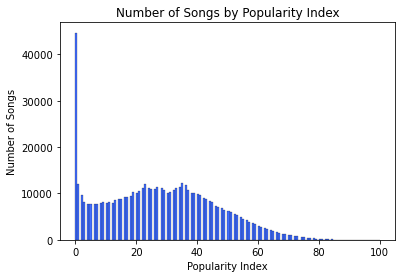

In [9]:
#Set palette to bright
sns.set_palette('bright')
#Graph popularity distribution
popularity = sns.histplot(x = df.popularity)
#Set labels
labels = popularity.set(ylabel = "Number of Songs", xlabel = "Popularity Index", title = "Number of Songs by Popularity Index")

The score 0 appears to be most common on the popularity index.

In [10]:
#Calculating the percent of songs with popularity index 0.
len(df[df.popularity == 0])/len(df)

0.07617544385960127

**Note**

Popular songs are overrepresented in our sample. The majority of Spotify's 70 million tracks of a popularity index of 0. In our data, only around 7.6% of the tracks have a popularity index of 0.

#### Duration

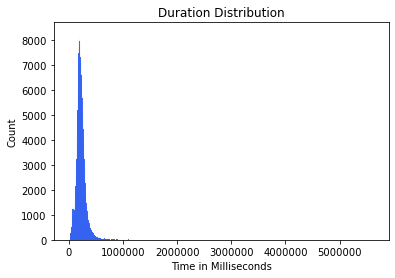

In [11]:
#Visualize duration distribution
duration = sns.histplot(df.duration_ms)
#Format ticks and labels
duration.ticklabel_format(useOffset=False, style='plain')
labels = duration.set(title = "Duration Distribution", xlabel = "Time in Milliseconds")

There appears to be some extreme outliers in length in our dataset. Let's see what some of the outliers are.

Here are the three longest tracks in our dataset.

In [12]:
df.sort_values(by = 'duration_ms', ascending = False).head(3)

id  \
326329  3EEv9UCeZdn4MVFv8tsO1E   
450241  7foc25ig7dibxvULPU2kBG   
131876  6rGikpwOv3LXaHWVCYbMNC   

                                                     name  popularity  \
326329                  โครงสร้างแห่งสิ่งที่เรียกว่าชีวิต           3   
450241                           Brown Noise - 90 Minutes          50   
131876  New Year's Eve 2015 Party Hits - Full DJ Party...           0   

        duration_ms  explicit              artists  \
326329      5621218         0      ['ท่านพุทธทาส']   
450241      5403500         0    ['Sound Dreamer']   
131876      5042185         0  ['Various Artists']   

                        id_artists release_date  danceability    energy  key  \
326329  ['2ySk9zib3PuomvMGmCqdTA']   1979-07-28         0.638  0.537000    8   
450241  ['4YJlpG8fCq38GnS8ElByiF']   2013-06-05         0.000  0.000099    2   
131876  ['0LyfQWJT6nXafLPZqxe9Of']   2014-12-19         0.457  0.891000   11   

        loudness  mode  speechiness  acousticness  instrumentalness  liveness  \
326329   -13.365     1       0.7750       0.82500           0.00000     0.345   
450241   -21.669     1       0.0000       0.11100           0.39200     0.137   
131876    -4.596     0       0.0627       0.00467           0.00109     0.294   

        valence    tempo  time_signature  
326329    0.401  131.446               3  
450241    0.000    0.000               0  
131876    0.731  129.516               4

In [13]:
#Calculate median song length
df.duration_ms.median()

214893.0

The longest track is around 90 minutes long. This track appears to be an extended religious prayer. The median song, however, is only around 3 and a half minutes long. 

#### Explicit

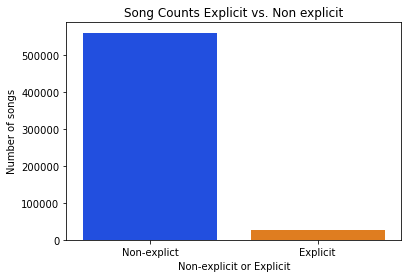

In [14]:
#Graph explicit vs. non-explicit value counts
explicit = sns.countplot(df.explicit)
#Format ticks and labels
explicit.set_xticklabels(['Non-explict','Explicit'])
labels = explicit.set(ylabel = "Number of songs", xlabel = "Non-explicit or Explicit", title = "Song Counts Explicit vs. Non explicit")

There are far more non-explicit songs that explicit songs.

#### Artist

Below is a chart of the the top twenty artists with the most tracks in the dataset.

In [15]:
df[['artists', 'id']].groupby('artists').count().sort_values(by = "id", ascending = False).head(20)

id
artists                                         
['Die drei ???']                            3856
['TKKG Retro-Archiv']                       2006
['Benjamin Blümchen']                       1503
['Bibi Blocksberg']                         1472
['Lata Mangeshkar']                         1373
['Bibi und Tina']                            927
['Tintin', 'Tomas Bolme', 'Bert-Åke Varg']   905
['Francisco Canaro']                         891
['Ella Fitzgerald']                          870
['Tadeusz Dolega Mostowicz']                 838
['Fünf Freunde']                             812
['Mohammed Rafi']                            787
['Queen']                                    777
['Elvis Presley']                            680
['Frank Sinatra']                            680
['The Rolling Stones']                       654
['Die Originale']                            638
['Billie Holiday']                           609
['Julio Iglesias']                           595
['Globi']                                    584

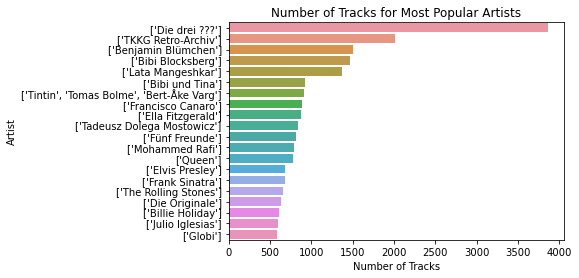

In [16]:
most_popular = df[['artists', 'id']].groupby('artists').count().sort_values(by = "id", ascending = False).head(20)
most_popular_barplot = sns.barplot(x = most_popular.id, y = most_popular.index)
labels = most_popular_barplot.set(title = "Number of Tracks for Most Popular Artists", xlabel = "Number of Tracks", ylabel = "Artist")

#### Release Date of the track

In [17]:
#We convert release date to datetime format to graph it more easily.
df.release_date = pd.to_datetime(df.release_date)

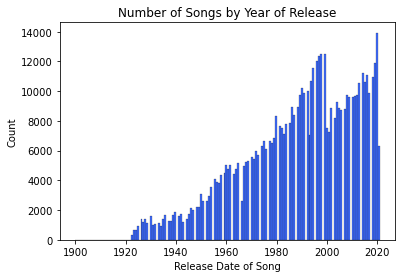

In [18]:
#Visualize release date distribution
release_dates = sns.histplot(df.release_date.dt.year)
#Set labels
labels = release_dates.set(xlabel = "Release Date of Song", title = "Number of Songs by Year of Release")

Our distribution is left-skewed, thus including more modern songs. There appears to be a particularly large amount of tracks from two periods:
 - the 1990s and
 - the current era 2019-2021.

#### Danceability

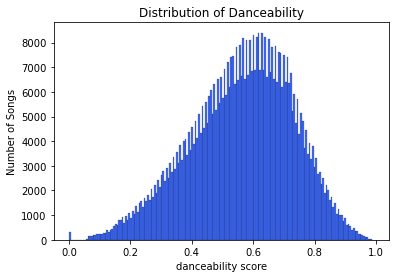

In [19]:
#Graph danceability distribution
danceability = sns.histplot(df.danceability)
#Show tick labels
labels = danceability.set(xlabel = "danceability score", ylabel = "Number of Songs", title = "Distribution of Danceability")

Danceability of the tracks is roughly normally distributed.

#### Energy 

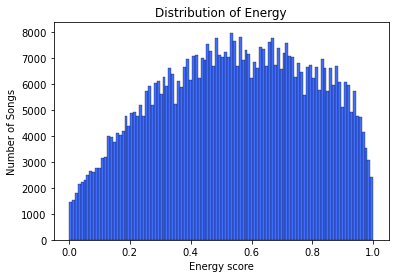

In [20]:
#Graph energy distribution
energy = sns.histplot(df.energy)
#Create ticks and labels
labels = energy.set(xlabel = "Energy score", ylabel = "Number of Songs", title = "Distribution of Energy")

Energy of each song is roughyl normally distributed.

#### Key

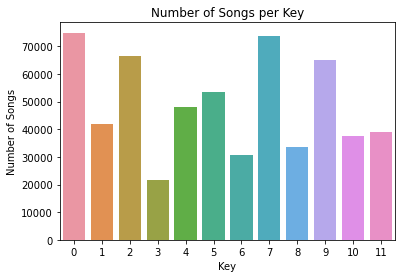

In [21]:
#Create countplot for each key value
key = sns.countplot(df.key)
#Create labels
labels = key.set(xlabel = "Key", ylabel = "Number of Songs", title = "Number of Songs per Key")

#### Loudness

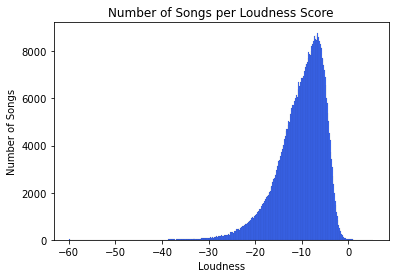

In [22]:
#Graph loudness distribution
loudness = sns.histplot(df.loudness)
#Create labels
labels = loudness.set(xlabel = "Loudness", ylabel = "Number of Songs", title = "Number of Songs per Loudness Score")

Loudness is roughly normally distributed with a left skew.

#### Mode

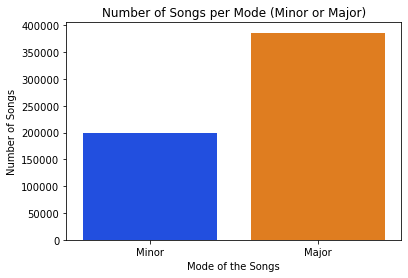

In [23]:
#Count of minor and major modes
mode = sns.countplot(df['mode'])
#Set tick labels
mode.set_xticklabels(['Minor','Major'])
labels = mode.set(xlabel = "Mode of the Songs", ylabel = "Number of Songs", title = "Number of Songs per Mode (Minor or Major)")

#### Speechiness

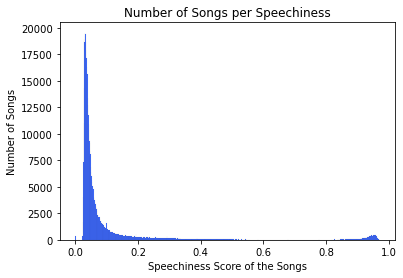

In [24]:
#Graph speechiness distribution
speechiness = sns.histplot(df['speechiness'])
#Create labels
labels = speechiness.set(xlabel = "Speechiness Score of the Songs", ylabel = "Number of Songs", title = "Number of Songs per Speechiness")

Speechiness is right-skew. There appears to be many outliers that are very high in speechiness, likely audiobooks or podcasts.

#### Acousticness

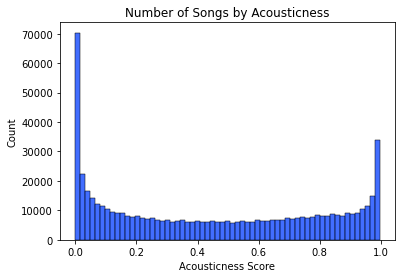

In [25]:
#Graph acousticness 
acousticness = sns.histplot(df.acousticness)
#Create labels
labels = acousticness.set(xlabel = "Acousticness Score", title = "Number of Songs by Acousticness")

#### Instrumentalness

**Note**

There were so many tracks with instrumentalness at 0 that the graph appeared empty if we simply graphed the raw data. Below we only graph the tracks with instrumentalness above 0.01.

The tracks with instrumentalnes 0 are likely audiobooks or podcasts.

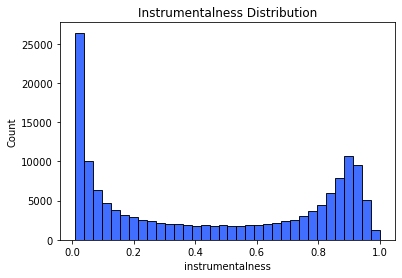

In [26]:
#Graph instrumentalness distribution
instrumentalness = sns.histplot(df[df.instrumentalness > 0.01].instrumentalness)
#Create labels
labels = instrumentalness.set(title = "Instrumentalness Distribution")

#### Liveness

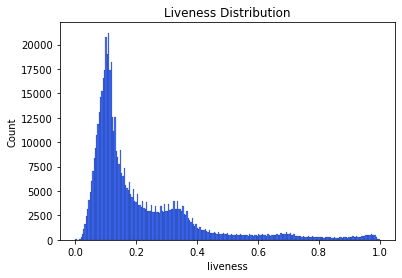

In [27]:
#Graph liveliness
liveness = sns.histplot(df.liveness)
#Create labels
labels = liveness.set(title = "Liveness Distribution")

Liveness is right skew.

#### Tempo

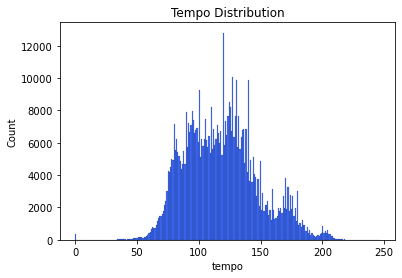

In [28]:
#Graph tempo
tempo = sns.histplot(df.tempo)
#Create labels
labels = tempo.set(title = "Tempo Distribution")

Tempo is roughly normally distributed.

#### Time Signature

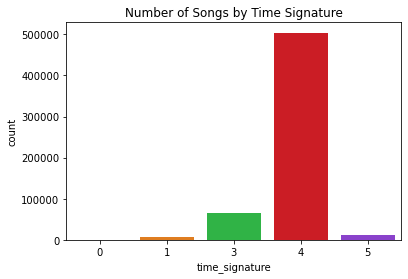

In [29]:
#Create time-signature distribution
time_signature = sns.countplot(df.time_signature)
#Create labels
labels = time_signature.set(title = "Number of Songs by Time Signature")

Unsurprisingly, 4/4 beats are most common.

### Key Takeaways

 - Most of our features have a roughly normal distribution. 
 - Our data has many outliers. 
 - Our dataset has categorical and continuous features. The categorical features are already numeric. 

## Prepare Data

Please see the `prepare.py` file in this repository for more information about the functions used to prepare the data in this section.

### Handle Missing Values

The `prepare_data` eliminates and rows or columns with excessive null values. The remaining null values are then imputed with the most frequent value of that column.

In [3]:
df = prepare_data(df)

### Remove Outliers

We remove the extreme outliers from our dataset.

In [4]:
df = data_no_outliers(df)

In [5]:
df = df.reset_index()

In [99]:
len(df)

403324

We have removed over 10_000 rows from the dataset.

### Date Column

For this project, I am going to conver the `release_date` column into `year_of_release`, since some of the values in the `release_date` column only contain data for year.

In [6]:
df['year_of_release'] = pd.to_datetime(df.release_date)
df['year_of_release'] = df['year_of_release'].dt.year

### Train, Validate, Test Split

In [7]:
train, validate, test = split_data(df)

In [8]:
len(train)

225861

In [9]:
len(validate)

96798

In [10]:
len(test)

80665

### Add Scaled Columns

Since `loudness` and `duration_ms` are not on the 0 to 1 scale, we scale those features using the Min-Max Scaler.

The Min-Max Scaler maps every value to a value between 0 and 1.

In [8]:
train, validate, test = add_scaled_columns(train, validate, test)

In [9]:
train.head()

index                      id                          name  \
336488  487178  2LJQHkTucSOJf9hQL0Q8ae                     Mein Ding   
318542  458324  1SwJzgDCwrpBGcvldOxDs1  Bonjour (V'là les nouvelles)   
243364  357260  3CQkJpY08xj0pB2jBeHUjV               Nirvana Kyuchek   
37863    65892  2dxRzFDDv3QcSMQ0vIgqMF        Brillante sobre el mic   
313199  450998  1xRP7GwKppuawKo4CbiTl2                  Bangun Cinta   

        popularity  duration_ms  explicit                           artists  \
336488          49       265587         0                ['Udo Lindenberg']   
318542          15       182960         0               ["Chagrin D'amour"]   
243364          28       241920         0  ['Slavi Trifonov', 'Ku-Ku Band']   
37863           51       248560         0                     ['Fito Paez']   
313199          52       202552         0                   ['3 Composers']   

                                               id_artists release_date  \
336488                         ['7iWcRnQMinCoV2u5ICgsW0']   2008-03-28   
318542                         ['1LTi4SuPK0G9juYKxU6AAG']   1982-01-01   
243364  ['4hcbbb8RBjFjCuMhmVv1b9', '6dTTAcKWN7BmRGAmmA...   2013-02-12   
37863                          ['1bZNv4q3OxYq7mmnLha7Tu']   1992-02-01   
313199                         ['145zDAbvELoocgZ4bZrSXe']   2018-04-13   

        danceability  ...  acousticness  instrumentalness  liveness  valence  \
336488         0.618  ...       0.00895          0.007490    0.0840    0.455   
318542         0.761  ...       0.29900          0.000000    0.3510    0.962   
243364         0.695  ...       0.01220          0.005590    0.0522    0.466   
37863          0.645  ...       0.17600          0.000003    0.2280    0.745   
313199         0.689  ...       0.68500          0.000000    0.1060    0.528   

          tempo  time_signature  year_of_release  duration_ms_scaled  \
336488  126.973               4             2008            0.497902   
318542  127.504               4             1982            0.341024   
243364   93.917               4             2013            0.452967   
37863   105.833               4             1992            0.465574   
313199   88.022               4             2018            0.378222   

        loudness_scaled  tempo_scaled  
336488         0.857457      0.531501  
318542         0.838799      0.533724  
243364         0.816115      0.393131  
37863          0.777793      0.443011  
313199         0.808668      0.368455  

[5 rows x 25 columns]

In [10]:
validate.head()

index                      id                 name  popularity  \
240365  352753  4qEHMJyER7OntYTtPsIT1W           11 RAZONES          63   
259209  377554  0jtguxOX9085ws8UtRiQv1    Mooi Weer Vandaag          35   
373606  546900  4YLfmYMEzdvnkgzKYjRKPw             ひとかけらの純情          20   
142758  221145  1n5JuPVZhc8gIeEaQnaxAu         Eshet Haikar           5   
340082  492501  5HPSvCWCM9TvsagA1idzuw  Speaking In Tongues          45   

        duration_ms  explicit                             artists  \
240365       213180         0                          ['Aitana']   
259209       217733         0                      ['Bart Kaell']   
373606       187320         0                    ['Saori Minami']   
142758       278518         0  ['Arik Einstein', 'Shalom Hanoch']   
340082       243227         1      ['Hilltop Hoods', 'Chali 2na']   

                                               id_artists release_date  \
240365                         ['7eLcDZDYHXZCebtQmVFL25']   2020-12-10   
259209                         ['7vwpGdC4NswrFH2szqnzy3']   1993-11-22   
373606                         ['4Q1uC5VlYJw6cnl37BkGS3']         1971   
142758  ['16XberediOtO5CaMrx85cR', '1Eks6sKVw6yepoeTbW...         1970   
340082  ['7dlqUnjoF2U2DkNDMhcgG4', '1ZJlXFkFDBsjSuYyjV...   2012-01-01   

        danceability  ...  acousticness  instrumentalness  liveness  valence  \
240365         0.550  ...       0.00599               0.0    0.2140    0.348   
259209         0.757  ...       0.14700               0.0    0.2490    0.817   
373606         0.689  ...       0.67600               0.0    0.1060    0.735   
142758         0.528  ...       0.21500               0.0    0.3860    0.732   
340082         0.691  ...       0.26300               0.0    0.0321    0.853   

          tempo  time_signature  year_of_release  duration_ms_scaled  \
240365  166.011               4             2020            0.398401   
259209  137.135               4             1993            0.407045   
373606  110.660               4             1971            0.349302   
142758   76.024               4             1970            0.522453   
340082   91.998               4             2012            0.455449   

        loudness_scaled  tempo_scaled  
240365         0.868063      0.694912  
259209         0.733525      0.574039  
373606         0.844621      0.463216  
142758         0.665970      0.318232  
340082         0.834975      0.385098  

[5 rows x 25 columns]

In [11]:
test.head()

index                      id                                name  \
49416    82801  0WDk4azsowshw4uPH9hM3s  Sweet Sorrow - Mono; 2009 Remaster   
199305  298030  2RUQPfpb1hJCkMsndlB7iG                        Mighty Quinn   
188400  282960  7DJoIiy2rwQmgq49ATq62v                      God Only Knows   
161999  248202  0kJN4zXuwYKp6k9UDvjSrM              Weekend in New England   
383661  559417  6fCfuXlm4OvK5OXwADQp8D                             ダカラドオシタ   

        popularity  duration_ms  explicit  \
49416            0       142627         0   
199305          28       389200         0   
188400          27       275400         0   
161999          32       224827         0   
383661          38       199124         0   

                                      artists                  id_artists  \
49416   ['Cliff Bennett & The Rebel Rousers']  ['4SwsfZi8Wl6WyKArywOjmR']   
199305          ["Manfred Mann's Earth Band"]  ['2utNxkLhreF1oIfO8kQT3q']   
188400                              ['James']  ['0qLNsNKm8bQcMoRFkR8Hmh']   
161999                      ['Barry Manilow']  ['3alW3LYQS8K29z8C8NSLIX']   
383661                            ['Arukara']  ['3FNVZovYeq27HeeJf3ogLU']   

       release_date  danceability  ...  acousticness  instrumentalness  \
49416    2009-04-06         0.445  ...      0.423000          0.000000   
199305         1978         0.379  ...      0.005780          0.003000   
188400         1990         0.318  ...      0.000371          0.001570   
161999         1973         0.255  ...      0.544000          0.000030   
383661   2012-07-25         0.578  ...      0.006350          0.000063   

        liveness  valence    tempo  time_signature  year_of_release  \
49416     0.0726    0.603  144.185               4             2009   
199305    0.0668    0.523  100.405               4             1978   
188400    0.2590    0.628  135.773               4             1990   
161999    0.1180    0.235   80.685               3             1973   
383661    0.0797    0.601  144.992               4             2012   

        duration_ms_scaled  loudness_scaled  tempo_scaled  
49416             0.264447         0.859810      0.603550  
199305            0.732597         0.744488      0.420289  
188400            0.516533         0.750325      0.568338  
161999            0.420514         0.766150      0.337743  
383661            0.371713         0.904868      0.606928  

[5 rows x 25 columns]

### Key Takeaways

 - There are no remaining null-values in our dataset. 
 
 - We removed outliers, which took approximately 10,000 rows out of our dataset.
 
 - We added in several new columns:
     - `year_of_release`,
     - `loudness_scaled`,  
     - `duration_ms_scaled`, 
     - `tempo_scaled`. 
     
 - We split our data into `train`, `validate`, and `test` datasets.

## Exploration

### Visualizations

In [12]:
continuous = ['danceability', 
              'energy', 
              'speechiness', 
              'acousticness', 
              'instrumentalness', 
              'liveness', 
              'valence', 
              'duration_ms_scaled',
              'loudness_scaled', 
              'tempo_scaled',
             'year_of_release']

categorical = ['explicit', 
               'key', 
               'mode', 
               'time_signature']

#### Univariate Visualizations

First let's see how preparing the data has changed the distribution of each feature.

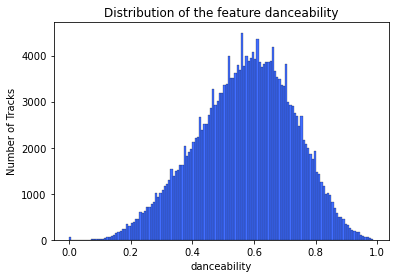

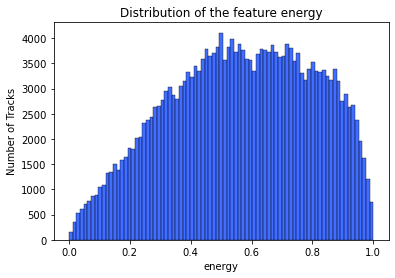

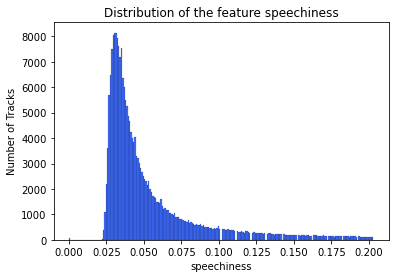

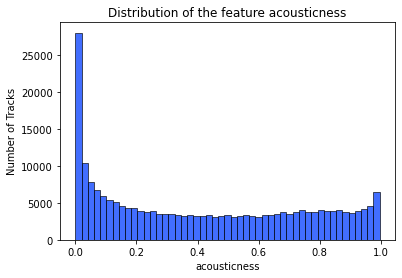

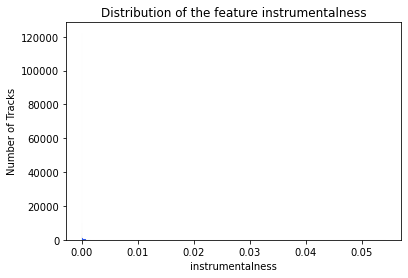

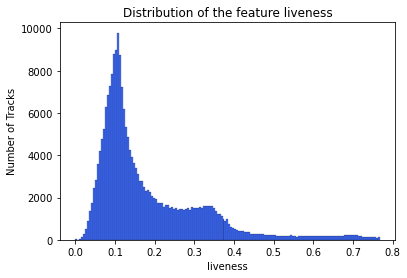

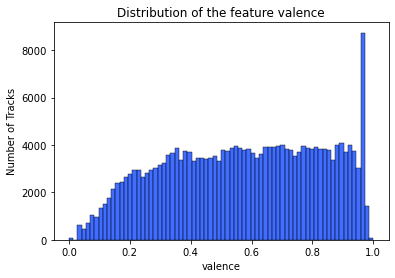

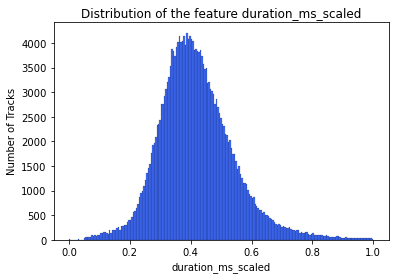

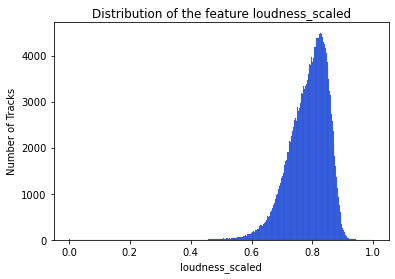

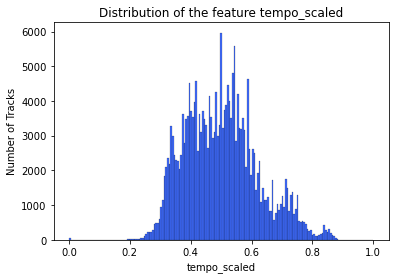

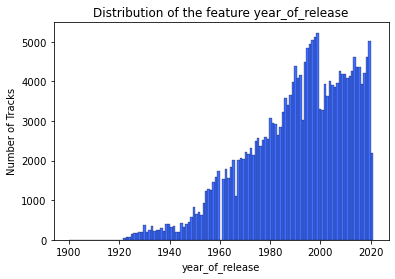

In [13]:
sns.set_palette("bright")
for col in continuous:

    figure = plt.figure
    ax = plt.gca()
    sns.histplot(train[col])
    ax.set_xlabel(col)
    ax.set_ylabel("Number of Tracks")
    ax.set_title("Distribution of the feature {}".format(col))

    plt.show()

Instrumentalness is still dominated with tracks with a 0 score, so we will graph the tracks with instrumentalness above 0.01.

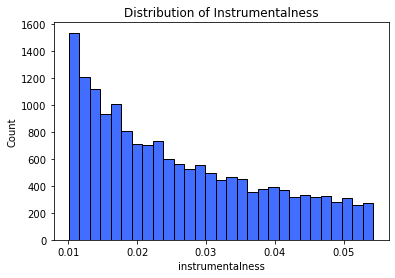

In [14]:
instrumentalness = sns.histplot(train.instrumentalness[train.instrumentalness > 0.01])
labels = instrumentalness.set(title = "Distribution of Instrumentalness")

Now we will graph the categorical features after preparation.

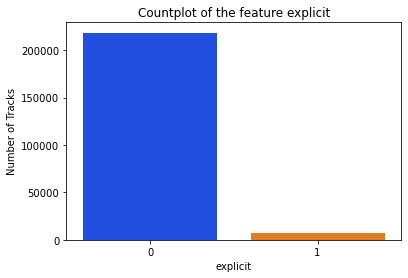

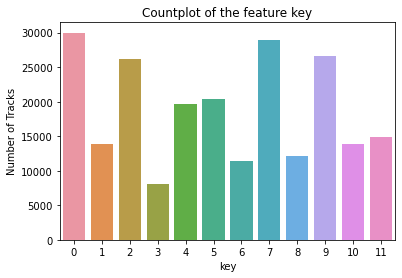

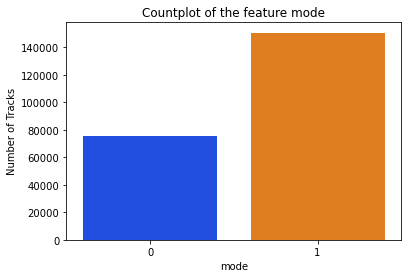

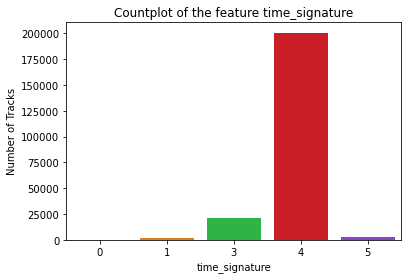

In [20]:
for col in categorical:

    figure = plt.figure
    ax = plt.gca()
    sns.countplot(train[col])
    ax.set_xlabel(col)
    ax.set_ylabel("Number of Tracks")
    ax.set_title("Countplot of the feature {}".format(col))

    plt.show()

Our distributions are roughly the same after preparing our data.

#### Bivariate Visualizations

We will graph a sample so the graph is not flooded.

In [15]:
sample = train.sample(1000)

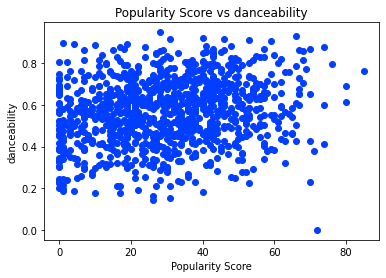

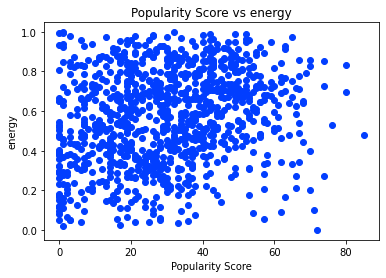

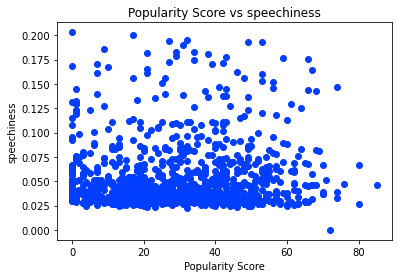

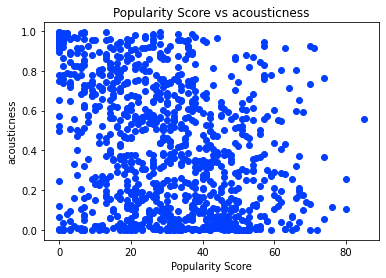

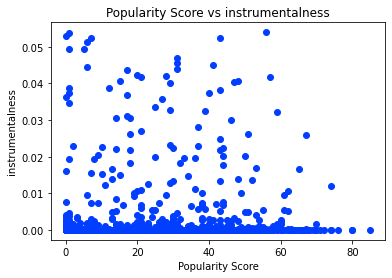

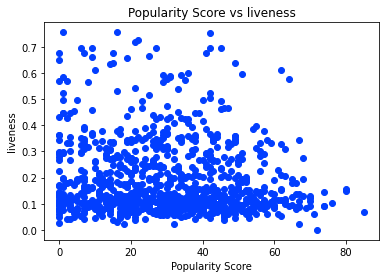

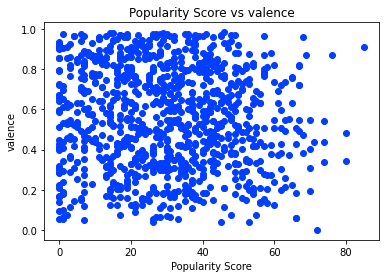

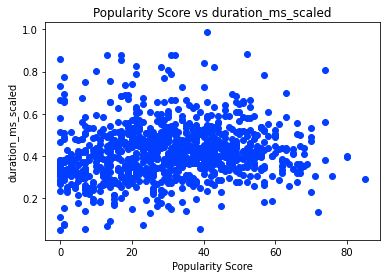

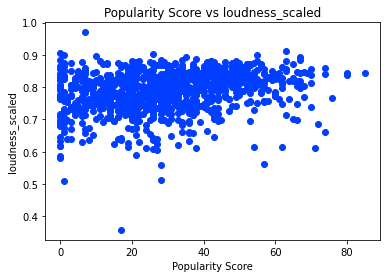

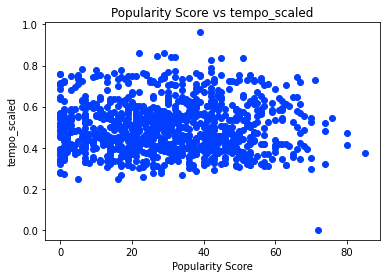

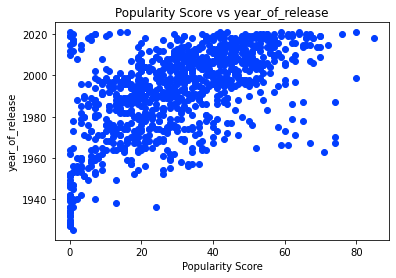

In [16]:
for y_col in continuous:

    figure = plt.figure
    ax = plt.gca()
    ax.scatter(sample.popularity, sample[y_col])
    ax.set_xlabel("Popularity Score")
    ax.set_ylabel(y_col)
    ax.set_title("{} vs {}".format("Popularity Score", y_col))

    plt.show()

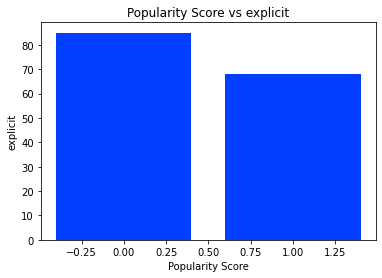

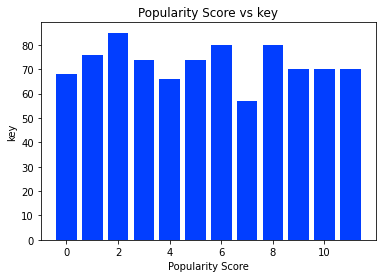

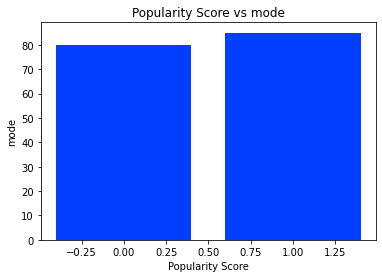

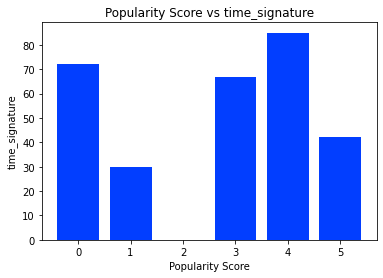

In [17]:
for y_col in categorical:

    figure = plt.figure
    ax = plt.gca()
    ax.bar(sample[y_col], sample.popularity)
    ax.set_xlabel("Popularity Score")
    ax.set_ylabel(y_col)
    ax.set_title("{} vs {}".format("Popularity Score", y_col))

    plt.show()

#### Multivariate Visualizations

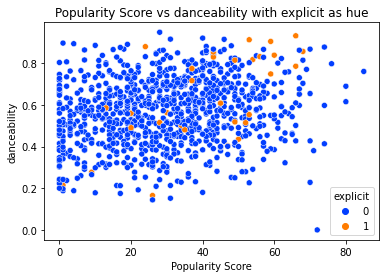

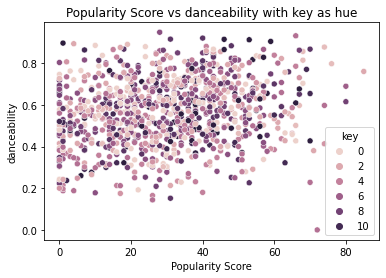

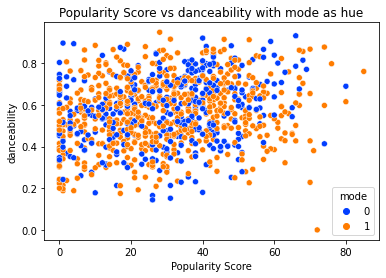

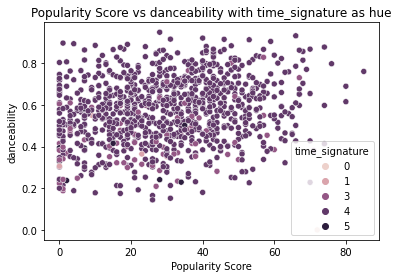

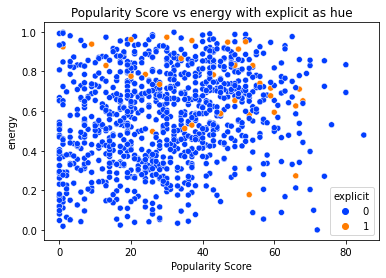

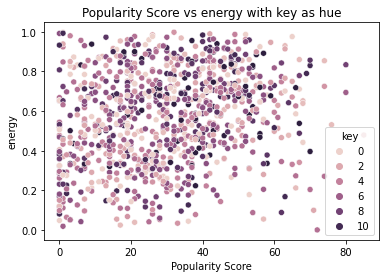

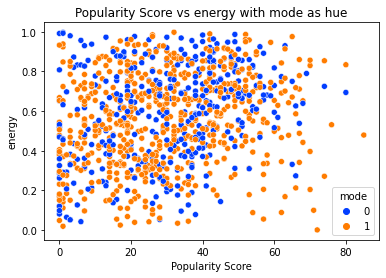

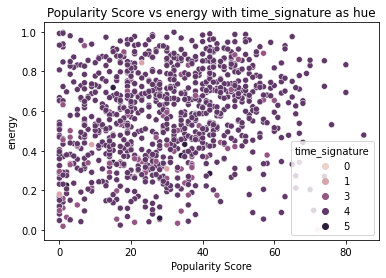

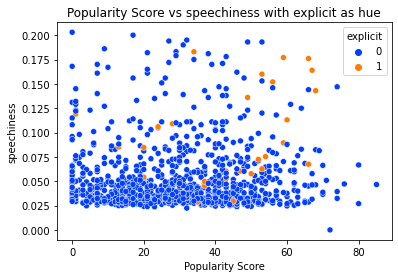

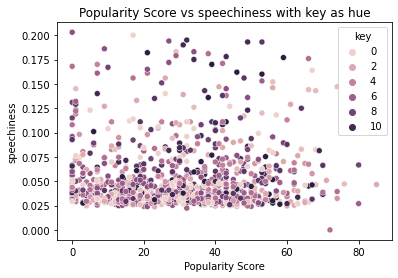

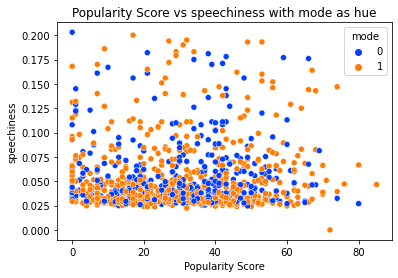

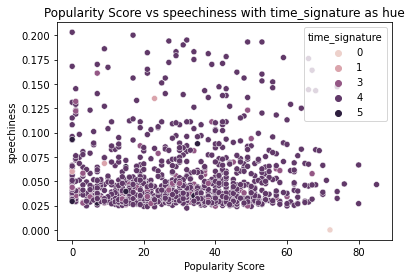

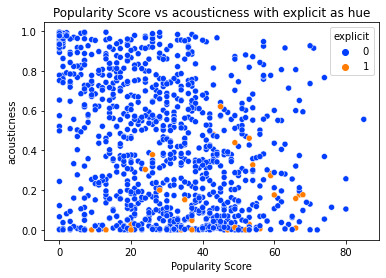

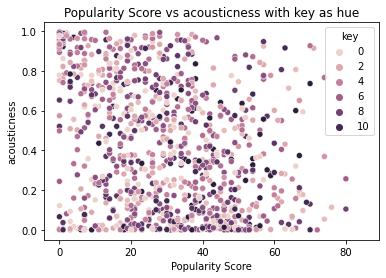

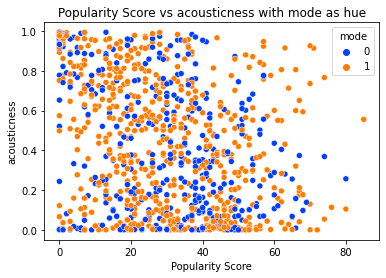

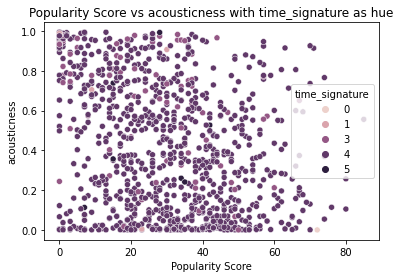

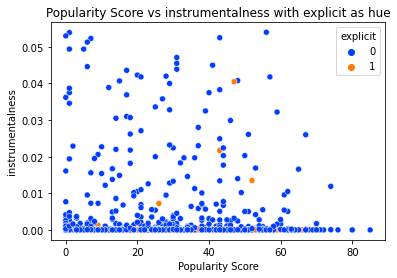

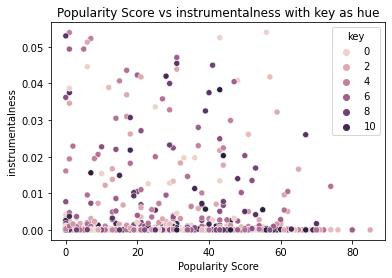

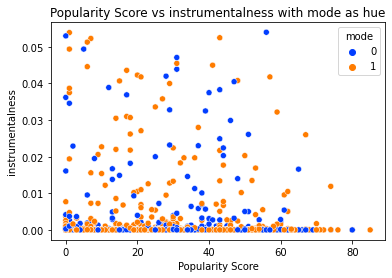

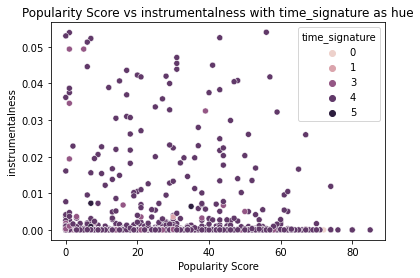

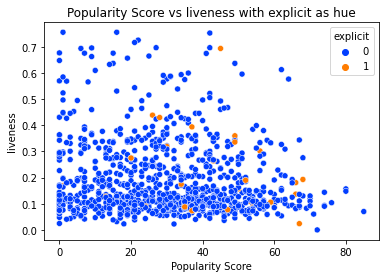

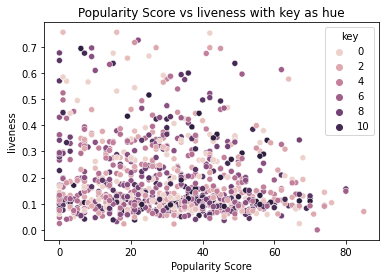

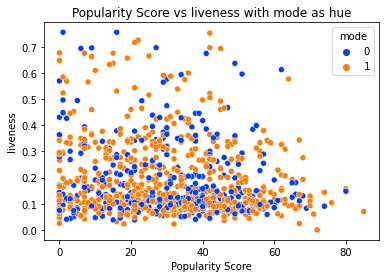

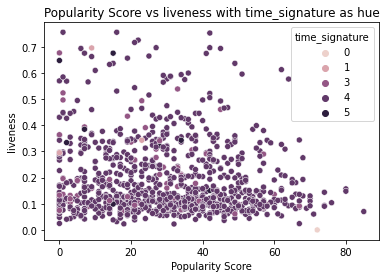

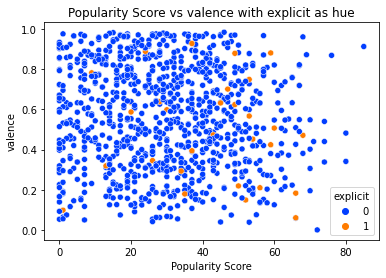

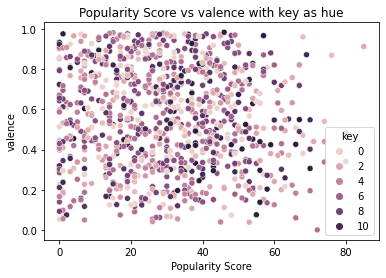

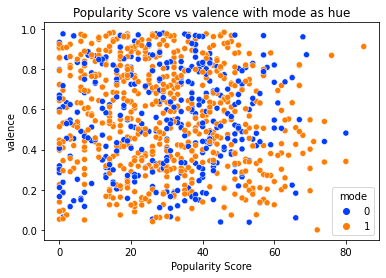

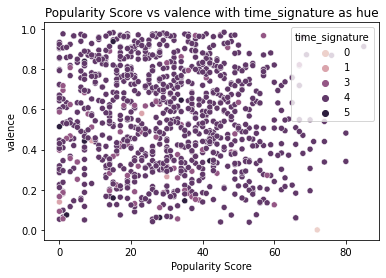

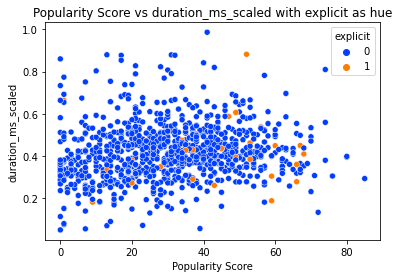

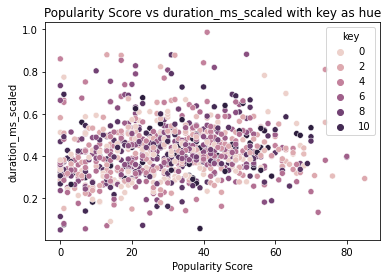

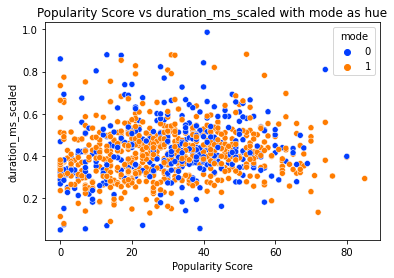

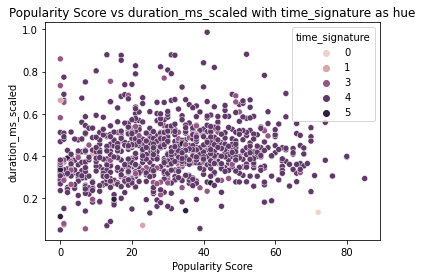

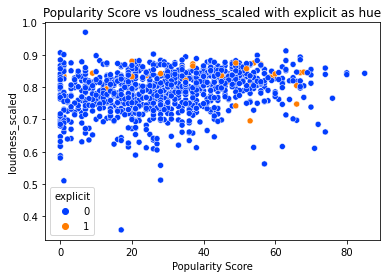

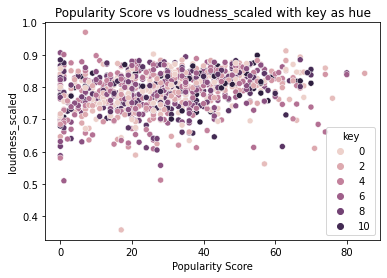

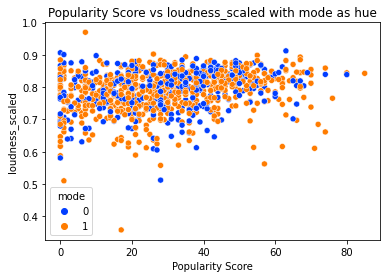

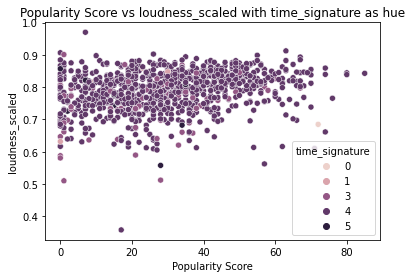

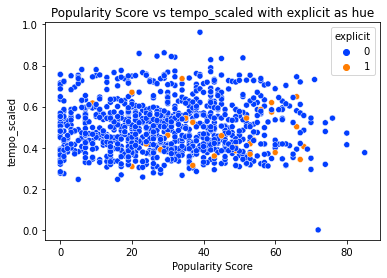

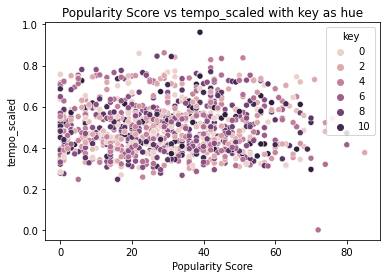

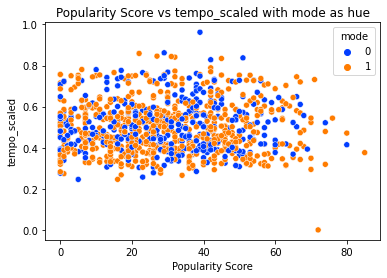

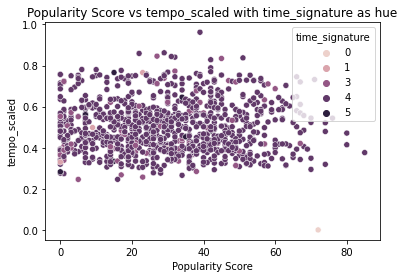

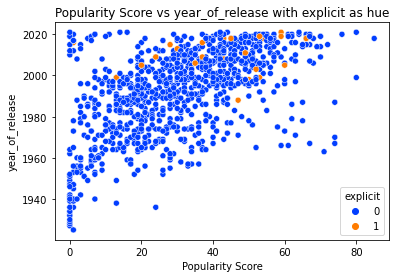

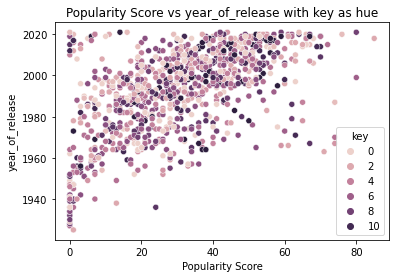

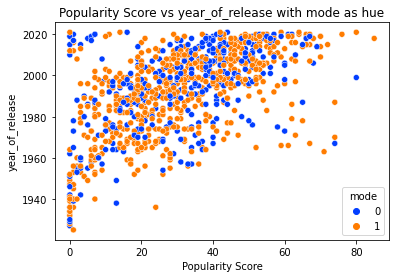

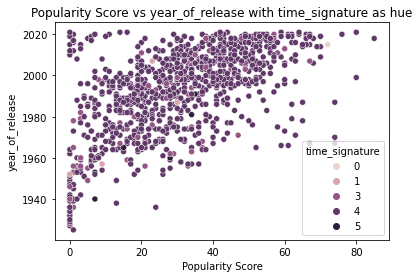

In [18]:
for y_col in continuous:
    for hue_col in categorical:
        figure = plt.figure
        ax = plt.gca()
        sns.scatterplot(x = sample.popularity, y = sample[y_col], hue = sample[hue_col])
        ax.set_xlabel("Popularity Score")
        ax.set_ylabel(y_col)
        ax.set_title("{} vs {} with {} as hue".format("Popularity Score", y_col, hue_col))

        plt.show()

### Feature Engineering

I will use feature engineering to determine which features are most likely predictive of `popularity`. To use, feature engineering, we first split the data between our features and our target.

In [19]:
train.columns

Index(['index', 'id', 'name', 'popularity', 'duration_ms', 'explicit',
       'artists', 'id_artists', 'release_date', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'year_of_release', 'duration_ms_scaled', 'loudness_scaled',
       'tempo_scaled'],
      dtype='object')

We create one dataset with our continuous variables, and one dataset with our target variable.

In [20]:
X_train = train[['explicit', 'danceability', 'energy', 'key', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'time_signature',
       'duration_ms_scaled', 'loudness_scaled', 'year_of_release', 'tempo_scaled']]
y_train = train['popularity']
X_validate = validate[['explicit', 'danceability', 'energy', 'key', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'time_signature', 
       'duration_ms_scaled', 'loudness_scaled', 'year_of_release', 'tempo_scaled']]
y_validate = validate.popularity
X_test = test[['explicit', 'danceability', 'energy', 'key', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence',  'time_signature',
       'duration_ms_scaled', 'loudness_scaled', 'year_of_release', 'tempo_scaled']]
y_test = test.popularity

In [21]:
len(X_train.columns)

15

In [22]:
len(X_validate.columns)

15

In [23]:
len(X_test.columns)

15

All of our datasets have the same number of columns. We will select the best features from our 15 columns.

#### Select K Best Model

In [24]:
# Create model
kbest_6 = SelectKBest(f_regression, k=6)
#Fit the model
kbest_6.fit(X_train, y_train)
X_train.columns[kbest_6.get_support()]

Index(['explicit', 'danceability', 'energy', 'acousticness', 'loudness_scaled',
       'year_of_release'],
      dtype='object')

In [25]:
# Create model
kbest_7 = SelectKBest(f_regression, k=7)
#Fit the model
kbest_7.fit(X_train, y_train)
X_train.columns[kbest_7.get_support()]

Index(['explicit', 'danceability', 'energy', 'acousticness',
       'duration_ms_scaled', 'loudness_scaled', 'year_of_release'],
      dtype='object')

In [26]:
# Create model
kbest_8 = SelectKBest(f_regression, k=8)
#Fit the model
kbest_8.fit(X_train, y_train)
X_train.columns[kbest_8.get_support()]

Index(['explicit', 'danceability', 'energy', 'acousticness', 'time_signature',
       'duration_ms_scaled', 'loudness_scaled', 'year_of_release'],
      dtype='object')

In [27]:
# Create model
kbest_9 = SelectKBest(f_regression, k=9)
#Fit the model
kbest_9.fit(X_train, y_train)
X_train.columns[kbest_9.get_support()]

Index(['explicit', 'danceability', 'energy', 'acousticness',
       'instrumentalness', 'time_signature', 'duration_ms_scaled',
       'loudness_scaled', 'year_of_release'],
      dtype='object')

In [28]:
# Create model
kbest_10 = SelectKBest(f_regression, k=10)
#Fit the model
kbest_10.fit(X_train, y_train)
X_train.columns[kbest_10.get_support()]

Index(['explicit', 'danceability', 'energy', 'acousticness',
       'instrumentalness', 'time_signature', 'duration_ms_scaled',
       'loudness_scaled', 'year_of_release', 'tempo_scaled'],
      dtype='object')

#### Recursive Feature Elimination

In [29]:
rfe_6 = RFE(estimator=LinearRegression(), n_features_to_select=6)
rfe_6.fit(X_train, y_train)
X_train.columns[rfe_6.get_support()]

Index(['explicit', 'danceability', 'acousticness', 'instrumentalness',
       'valence', 'loudness_scaled'],
      dtype='object')

In [30]:
rfe_7 = RFE(estimator=LinearRegression(), n_features_to_select=7)
rfe_7.fit(X_train, y_train)
X_train.columns[rfe_7.get_support()]

Index(['explicit', 'danceability', 'acousticness', 'instrumentalness',
       'valence', 'duration_ms_scaled', 'loudness_scaled'],
      dtype='object')

In [31]:
rfe_8 = RFE(estimator=LinearRegression(), n_features_to_select=8)
rfe_8.fit(X_train, y_train)
X_train.columns[rfe_8.get_support()]

Index(['explicit', 'danceability', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'duration_ms_scaled', 'loudness_scaled'],
      dtype='object')

In [32]:
rfe_9 = RFE(estimator=LinearRegression(), n_features_to_select=9)
rfe_9.fit(X_train, y_train)
X_train.columns[rfe_9.get_support()]

Index(['explicit', 'danceability', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'duration_ms_scaled', 'loudness_scaled',
       'tempo_scaled'],
      dtype='object')

In [33]:
rfe_10 = RFE(estimator=LinearRegression(), n_features_to_select=10)
rfe_10.fit(X_train, y_train)
X_train.columns[rfe_10.get_support()]

Index(['explicit', 'danceability', 'energy', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'duration_ms_scaled',
       'loudness_scaled', 'tempo_scaled'],
      dtype='object')

### Stastistical Testing

In [34]:
train.columns

Index(['index', 'id', 'name', 'popularity', 'duration_ms', 'explicit',
       'artists', 'id_artists', 'release_date', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'year_of_release', 'duration_ms_scaled', 'loudness_scaled',
       'tempo_scaled'],
      dtype='object')

In [35]:
continuous = ['danceability', 
              'energy', 
              'speechiness', 
              'acousticness', 
              'instrumentalness', 
              'liveness', 
              'valence', 
              'duration_ms_scaled',
              'loudness_scaled', 
             'year_of_release',
             'tempo_scaled']

In [36]:
categorical = ['explicit', 
               'key', 
               'mode', 
               'time_signature']

#### Continuous Variables

For the following hypothesis testing we will set our alpha value equal to 0.05.

Our initial hypotheses are as follows:

In [37]:
class color:
    BOLD = '\033[1m'
    END = '\033[0m'


for col in continuous:
    print(color.BOLD + "Null Hypothesis:" + color.END, "The feature", col, "is not significantly correlated with popularity.")
    print(" ")
    print(color.BOLD + "Alternative Hypothesis:" + color.END, "The feature", col, "is  significantly correlated with popularity.")
    print(" ")
    print(" ")

Null Hypothesis: The feature danceability is not significantly correlated with popularity.
 
Alternative Hypothesis: The feature danceability is  significantly correlated with popularity.
 
 
Null Hypothesis: The feature energy is not significantly correlated with popularity.
 
Alternative Hypothesis: The feature energy is  significantly correlated with popularity.
 
 
Null Hypothesis: The feature speechiness is not significantly correlated with popularity.
 
Alternative Hypothesis: The feature speechiness is  significantly correlated with popularity.
 
 
Null Hypothesis: The feature acousticness is not significantly correlated with popularity.
 
Alternative Hypothesis: The feature acousticness is  significantly correlated with popularity.
 
 
Null Hypothesis: The feature instrumentalness is not significantly correlated with popularity.
 
Alternative Hypothesis: The feature instrumentalness is  significantly correlated with popularity.
 
 
Null Hypothesis: The feature liveness is not s

In [38]:
for col in continuous:
    test_results = stats.pearsonr(train.popularity, train[col])
    print(col, "correlation with popularity")
    print(test_results)
    print(" ")

danceability correlation with popularity
(0.18020386463504842, 0.0)
 
energy correlation with popularity
(0.27672839319065057, 0.0)
 
speechiness correlation with popularity
(0.055828584591628455, 2.370959732839039e-155)
 
acousticness correlation with popularity
(-0.3335203623490612, 0.0)
 
instrumentalness correlation with popularity
(-0.07691420927084033, 2.1823153326026428e-293)
 
liveness correlation with popularity
(-0.05588177045460099, 1.2083850961502185e-155)
 
valence correlation with popularity
(-0.02735018291956476, 1.215630639174514e-38)
 
duration_ms_scaled correlation with popularity
(0.13245755026137265, 0.0)
 
loudness_scaled correlation with popularity
(0.3125440997278433, 0.0)
 
year_of_release correlation with popularity
(0.5734156543184376, 0.0)
 
tempo_scaled correlation with popularity
(0.05634799841046045, 3.1934178947168853e-158)
 


We reject the null hypothesis for all of our continuous features except `valence`.

All continuous variables except for `valence` are significantly correlated with `popularity`. However, 
 - danceability, 
 - energy, 
 - instrumentalness, 
 - tempo, 
 - duration_ms_scaled, 
 - loudness_scaled, and 
 - year_of_release

appear to have particularly strong correlation to `popularity`.

#### Categorical Variables

**Explicit**

In [7]:
print(color.BOLD + "Null Hypothesis:" + color.END, "There is no significant difference in mean for explicit and non-explicit tracks.")
print("")
print(color.BOLD + "Alternative Hypothesis:" + color.END, "There is no significant difference in mean for explicit and non-explicit tracks.")

Null Hypothesis: There is no significant difference in mean for explicit and non-explicit tracks.

Alternative Hypothesis: There is no significant difference in mean for explicit and non-explicit tracks.


In [33]:
explicit_popularity = train[train.explicit == 1].popularity
nonexplicit_popularity = train[train.explicit == 0].popularity


test_results = stats.ttest_ind(explicit_popularity, nonexplicit_popularity)
test_results

Ttest_indResult(statistic=86.94020920473926, pvalue=0.0)

We reject the null hypothesis.

**Key**

In [4]:
for i in range(0, 12):
    print("Key", i)
    print(color.BOLD + "Null Hypothesis:" + color.END, "The mean popularity for the populatin with key", i, "is not significantly different than overall population mean popularity.")
    print("")
    print(color.BOLD + "Alternative Hypothesis:" + color.END, "The mean popularity for the populatin with key", i, "is significantly different than overall population mean popularity.")
    print("")
    print("")

Key 0
Null Hypothesis: The mean popularity for the populatin with key 0 is not significantly different than overall population mean popularity.

Alternative Hypothesis: The mean popularity for the populatin with key 0 is significantly different than overall population mean popularity.


Key 1
Null Hypothesis: The mean popularity for the populatin with key 1 is not significantly different than overall population mean popularity.

Alternative Hypothesis: The mean popularity for the populatin with key 1 is significantly different than overall population mean popularity.


Key 2
Null Hypothesis: The mean popularity for the populatin with key 2 is not significantly different than overall population mean popularity.

Alternative Hypothesis: The mean popularity for the populatin with key 2 is significantly different than overall population mean popularity.


Key 3
Null Hypothesis: The mean popularity for the populatin with key 3 is not significantly different than overall population mean popu

In [54]:
for a in range(0, 12):
    key_popularity = train[train.key == a].popularity
    
    test_results = stats.ttest_1samp(key_popularity, overall_popularity_mean)
    
    print("Key", a, "popularity compared to population mean")
    
    print(test_results)
    
    print(" ")


Key 0 popularity compared to population mean
Ttest_1sampResult(statistic=-7.112900720424216, pvalue=1.1617400899452116e-12)
 
Key 1 popularity compared to population mean
Ttest_1sampResult(statistic=21.474733068454988, pvalue=1.1446646262627384e-100)
 
Key 2 popularity compared to population mean
Ttest_1sampResult(statistic=-8.52516969998698, pvalue=1.606725756921519e-17)
 
Key 3 popularity compared to population mean
Ttest_1sampResult(statistic=-12.235501062267867, pvalue=4.036396249258758e-34)
 
Key 4 popularity compared to population mean
Ttest_1sampResult(statistic=-0.4732096915235414, pvalue=0.6360688417049315)
 
Key 5 popularity compared to population mean
Ttest_1sampResult(statistic=-13.312138549746315, pvalue=2.899858472944191e-40)
 
Key 6 popularity compared to population mean
Ttest_1sampResult(statistic=18.355782698931833, pvalue=3.4957739909639555e-74)
 
Key 7 popularity compared to population mean
Ttest_1sampResult(statistic=-7.217821158516747, pvalue=5.412747469667133e-13)

We reject the null hypothesis for all key values except 4 and 9. 

The majority of key popularities do not differ significantly from the mean population popularity. 

**Mode**

In [5]:
print(color.BOLD + "Null Hypothesis:" + color.END, "There is no significant difference in mean for tracks in major or minor mode.")
print("")
print(color.BOLD + "Alternative Hypothesis:" + color.END, "There is no significant difference in mean for tracks in major or minor mode.")

Null Hypothesis: There is no significant difference in mean for tracks in major or minor mode.

Alternative Hypothesis: There is no significant difference in mean for tracks in major or minor mode.


In [39]:
major_popularity = train[train['mode'] == 1].popularity
minor_popularity = train[train['mode'] == 0].popularity

test_results = stats.ttest_ind(major_popularity, minor_popularity)
test_results

Ttest_indResult(statistic=-12.207459442933576, pvalue=2.907574890344631e-34)

We reject the null hypothesis.

The mean popularity for songs in major is significantly different than mean popularity for songs in minor.

**Time Signature**

In [6]:
for i in range(0, 5):
    print("Time Signature", i)
    print(color.BOLD + "Null Hypothesis:" + color.END, "The mean popularity for the populatin with time signature", i, "is not significantly different than overall population mean popularity.")
    print("")
    print(color.BOLD + "Alternative Hypothesis:" + color.END, "The mean popularity for the populatin with time signature", i, "is significantly different than overall population mean popularity.")
    print("")
    print("")

Time Signature 0
Null Hypothesis: The mean popularity for the populatin with time signature 0 is not significantly different than overall population mean popularity.

Alternative Hypothesis: The mean popularity for the populatin with time signature 0 is significantly different than overall population mean popularity.


Time Signature 1
Null Hypothesis: The mean popularity for the populatin with time signature 1 is not significantly different than overall population mean popularity.

Alternative Hypothesis: The mean popularity for the populatin with time signature 1 is significantly different than overall population mean popularity.


Time Signature 2
Null Hypothesis: The mean popularity for the populatin with time signature 2 is not significantly different than overall population mean popularity.

Alternative Hypothesis: The mean popularity for the populatin with time signature 2 is significantly different than overall population mean popularity.


Time Signature 3
Null Hypothesis: The

In [229]:
for a in range(0, 5):
    time_signature_popularity = train[train.time_signature == a].popularity
    
    test_results = stats.ttest_1samp(time_signature_popularity, overall_popularity_mean)
    
    print("Time signature", a, "popularity compared to population mean")
    
    print(test_results)
    
    print(" ")

Time signature 0 popularity compared to population mean
Ttest_1sampResult(statistic=1.5012071253882808, pvalue=0.135073792340418)
 
Time signature 1 popularity compared to population mean
Ttest_1sampResult(statistic=-24.906015326592804, pvalue=1.2576858249544887e-126)
 
Time signature 2 popularity compared to population mean
Ttest_1sampResult(statistic=nan, pvalue=nan)
 
Time signature 3 popularity compared to population mean
Ttest_1sampResult(statistic=-63.360324617088516, pvalue=0.0)
 
Time signature 4 popularity compared to population mean
Ttest_1sampResult(statistic=27.676013005754115, pvalue=2.284643662687771e-168)
 


We reject the null hypothesis for all of our time signature values, except 2, for which there is insufficient data.

The means are significantly different from the total population for every time signature except time signature 0 and time signature 2. 

### Key Takeaways

 - We visualized the features in the datasets. 
     - The features `loudness_scaled` and `explicit` stand out in the visualizations as two features likely predictive of `popularity`.
     
 
 - Select K Best Model indicates that that the following features are likely the most predictive of `popularity`:
     - explicit, 
     - danceability, 
     - energy, 
     - acousticness, 
     - loudness_scaled, and
     - year_of_release
     

 - Recursive Feature Elimination indicates that the following features are likely the most predictive of `popularity`: 
     - explicit, 
     - danceability, 
     - acousticness, 
     - instrumentalness,
     - valence, and
     - loudness_scaled
     
    
 - Our statistical testing confirms that all of these features (except valence) are indeed associated with popularity.

## Modeling

**Note on Quality Control** 

All of our data points that we will use are numeric. Our target features `popularity` is numeric. The only contiuous three features that are not on a 0 to 1 scale (`duration_ms`, `loudness`, and `tempo`) have been scaled.

### Splitting Target and Features

First we will need to split our data into y, for the target, and X, for the predictive features.

In [39]:
y_train = train['popularity']
y_validate = validate['popularity']
y_test = test['popularity']

In [40]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

Based on our findings from our Explore section, we select the  features below for our model.

In [41]:
X_train = train[['duration_ms_scaled', 
                 'explicit', 
                 'energy', 
                 'danceability', 
                 'acousticness', 
                 'instrumentalness',
                 'loudness_scaled', 
                 'year_of_release',
                'liveness',
                'tempo_scaled']]
X_validate = validate[['duration_ms_scaled',
                       'explicit', 
                       'energy',  
                       'danceability', 
                       'acousticness', 
                       'instrumentalness',
                        'loudness_scaled', 
                       'year_of_release',
                      'liveness',
                      'tempo_scaled']]
X_test = test[['duration_ms_scaled', 
               'explicit', 
               'energy', 
               'danceability', 
               'acousticness', 
               'instrumentalness',
               'loudness_scaled', 
               'year_of_release',
              'liveness',
              'tempo_scaled']]

### Baseline

We will create a baseline to which we can compare our models.

In [42]:
# Predict taxvaluedollarcnt_pred_mean
popularity_pred_mean = y_train.popularity.mean()
y_train['popularity_pred_mean'] = popularity_pred_mean
y_validate['popularity_pred_mean'] = popularity_pred_mean

In [43]:
# compute taxvaluedollarcnt_pred_median
popularity_pred_median = y_train.popularity.median()
y_train['popularity_pred_median'] = popularity_pred_median
y_validate['popularity_pred_median'] = popularity_pred_median

In [44]:
y_train.head()

popularity  popularity_pred_mean  popularity_pred_median
336488          49             29.737591                    29.0
318542          15             29.737591                    29.0
243364          28             29.737591                    29.0
37863           51             29.737591                    29.0
313199          52             29.737591                    29.0

In [45]:
y_validate.head()

popularity  popularity_pred_mean  popularity_pred_median
240365          63             29.737591                    29.0
259209          35             29.737591                    29.0
373606          20             29.737591                    29.0
142758           5             29.737591                    29.0
340082          45             29.737591                    29.0

In [46]:
# RMSE of taxvaluedollarcnt_pred_mean
rmse_train = mean_squared_error(y_train.popularity, y_train.popularity_pred_mean) ** .5
rmse_validate = mean_squared_error(y_validate.popularity, y_validate.popularity_pred_mean) ** (1/2)
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# RMSE of taxvaluedollarcnt_pred_median
rmse_train = mean_squared_error(y_train.popularity, y_train.popularity_pred_median) ** .5
rmse_validate = mean_squared_error(y_validate.popularity, y_validate.popularity_pred_median) ** .5
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  17.81 
Validate/Out-of-Sample:  17.76
RMSE using Median
Train/In-Sample:  17.82 
Validate/Out-of-Sample:  17.78


### Build DataFrame

We will build a DataFrame to hold the different results for our models.

In [47]:
from sklearn.metrics import explained_variance_score

In [48]:
def make_metric_df(y, y_pred, model_name, metric_df):
    if metric_df.size ==0:
        metric_df = pd.DataFrame(data=[
            {
                'model': model_name, 
                'RMSE_validate': mean_squared_error(
                    y,
                    y_pred) ** .5,
                'r^2_validate': explained_variance_score(
                    y,
                    y_pred)
            }])
        return metric_df
    else:
        return metric_df.append(
            {
                'model': model_name, 
                'RMSE_validate': mean_squared_error(
                    y,
                    y_pred) ** .5,
                'r^2_validate': explained_variance_score(
                    y,
                    y_pred)
            }, ignore_index=True)

In [49]:
metric_df = pd.DataFrame()
metric_df = make_metric_df(y_validate.popularity,
                           y_validate.popularity_pred_median,
                           'median_baseline',
                          metric_df)

In [50]:
metric_df

model  RMSE_validate  r^2_validate
0  median_baseline       17.77673           0.0

Now we will create a series of models for our data.

### Linear Regression (OLS)

In [51]:
#Create the model object
lm_1 = LinearRegression(normalize=True)

# fit the model to training data
lm_1.fit(X_train, y_train.popularity)

y_train['popularity_pred_lm_1'] = lm_1.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.popularity, y_train.popularity_pred_lm_1) ** (1/2)

# predict validate
y_validate['popularity_pred_lm_1'] = lm_1.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.popularity, y_validate.popularity_pred_lm_1) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  14.391677049149573 
Validation/Out-of-Sample:  14.408118240994641


In [52]:
metric_df = make_metric_df(y_validate.popularity, y_validate.popularity_pred_lm_1,
               'OLS Regressor, Select Features',
               metric_df)

In [53]:
metric_df

model  RMSE_validate  r^2_validate
0                 median_baseline      17.776730      0.000000
1  OLS Regressor, Select Features      14.408118      0.341824

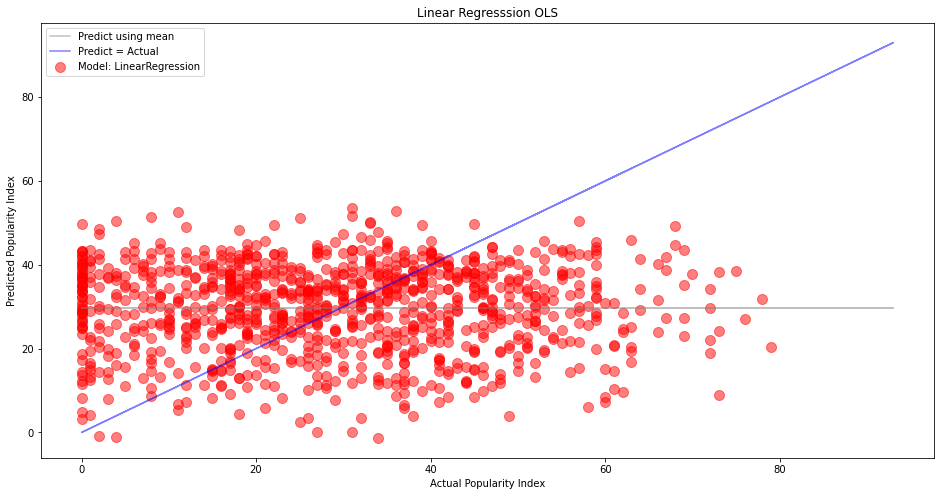

In [54]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.popularity, y_validate.popularity_pred_mean, alpha=.5, color="gray", label='Predict using mean')
plt.plot(y_validate.popularity, y_validate.popularity, alpha=.5, color="blue", label='Predict = Actual')
plt.scatter(y_validate.sample(1000).popularity, y_validate.sample(1000).popularity_pred_lm_1, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.legend()
plt.xlabel("Actual Popularity Index")
plt.ylabel("Predicted Popularity Index")
plt.title("Linear Regresssion OLS")
plt.show()

### LassoLars

In [55]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data.
lars.fit(X_train, y_train.popularity)

# predict train
y_train['popularity_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.popularity, y_train.popularity_pred_lars) ** (1/2)

# predict validate
y_validate['popularity_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.popularity, y_validate.popularity_pred_lars) ** (1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  17.806588084186668 
Validation/Out-of-Sample:  17.75977012749067


In [56]:
metric_df = make_metric_df(y_validate.popularity, y_validate.popularity_pred_lars,
               'lasso_alpha_1',
               metric_df)

In [57]:
metric_df

model  RMSE_validate  r^2_validate
0                 median_baseline      17.776730      0.000000
1  OLS Regressor, Select Features      14.408118      0.341824
2                   lasso_alpha_1      17.759770      0.000000

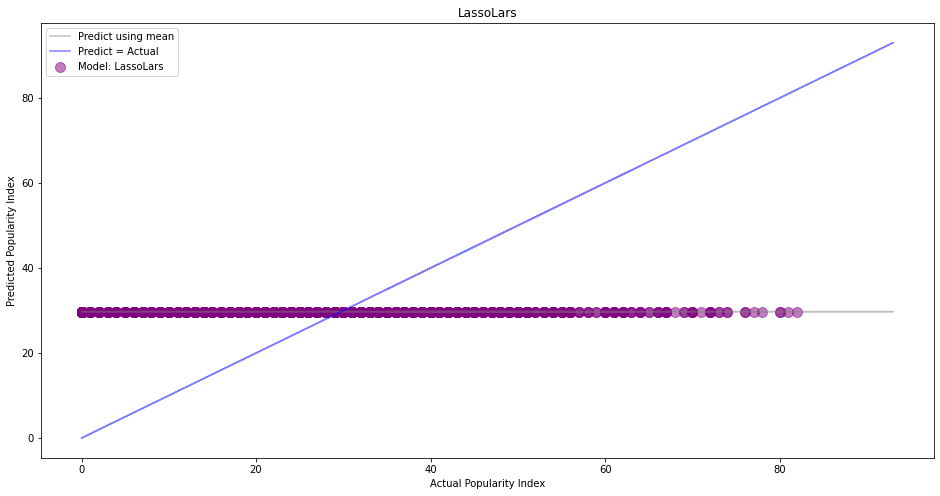

In [58]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.popularity, y_validate.popularity_pred_mean, alpha=.5, color="gray", label='Predict using mean')
plt.plot(y_validate.popularity, y_validate.popularity, alpha=.5, color="blue", label='Predict = Actual')
plt.scatter(y_validate.sample(1000).popularity, y_validate.sample(1000).popularity_pred_lars, 
            alpha=.5, color="purple", s=100, label="Model: LassoLars")
plt.legend()
plt.xlabel("Actual Popularity Index")
plt.ylabel("Predicted Popularity Index")
plt.title("LassoLars")
plt.show()

### Tweedie Regressor

In [59]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0.5)


# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.popularity)

# predict train
y_train['popularity_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.popularity, y_train.popularity_pred_glm) ** (1/2)

# predict validate
y_validate['popularity_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.popularity, y_validate.popularity_pred_glm) ** (1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0.5\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0.5
Training/In-Sample:  17.80658808418667 
Validation/Out-of-Sample:  17.75977012749067


In [60]:
metric_df = make_metric_df(y_validate.popularity, y_validate.popularity_pred_glm,
               'GLM',
               metric_df)
metric_df

model  RMSE_validate  r^2_validate
0                 median_baseline      17.776730      0.000000
1  OLS Regressor, Select Features      14.408118      0.341824
2                   lasso_alpha_1      17.759770      0.000000
3                             GLM      17.759770      0.000000

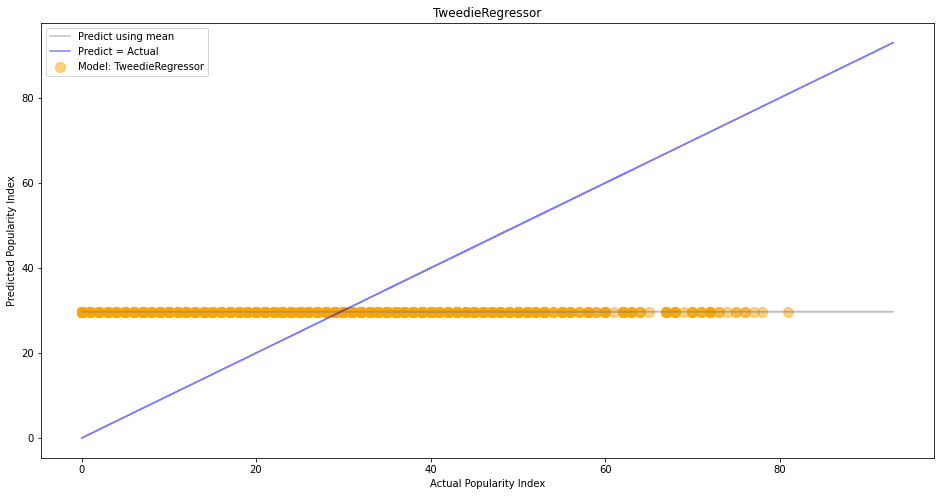

In [61]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.popularity, y_validate.popularity_pred_mean, alpha=.5, color="gray", label='Predict using mean')
plt.plot(y_validate.popularity, y_validate.popularity, alpha=.5, color="blue", label='Predict = Actual')
plt.scatter(y_validate.sample(1000).popularity, y_validate.sample(1000).popularity_pred_glm, 
            alpha=.5, color="orange", s=100, label="Model: TweedieRegressor")
plt.legend()
plt.xlabel("Actual Popularity Index")
plt.ylabel("Predicted Popularity Index")
plt.title("TweedieRegressor")
plt.show()

### Linear Regression Second Degree

In [62]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 =  pf.transform(X_test)

In [63]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.popularity)

# predict train
y_train['popularity_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.popularity, y_train.popularity_pred_lm2) ** (1/2)

# predict validate
y_validate['popularity_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.popularity, y_validate.popularity_pred_lm2) ** (1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  14.176745252886878 
Validation/Out-of-Sample:  14.192519863463072


In [64]:
metric_df = make_metric_df(y_validate.popularity, y_validate.popularity_pred_lm2,
               'quadratic',
               metric_df)

metric_df

model  RMSE_validate  r^2_validate
0                 median_baseline      17.776730      0.000000
1  OLS Regressor, Select Features      14.408118      0.341824
2                   lasso_alpha_1      17.759770      0.000000
3                             GLM      17.759770      0.000000
4                       quadratic      14.192520      0.361374

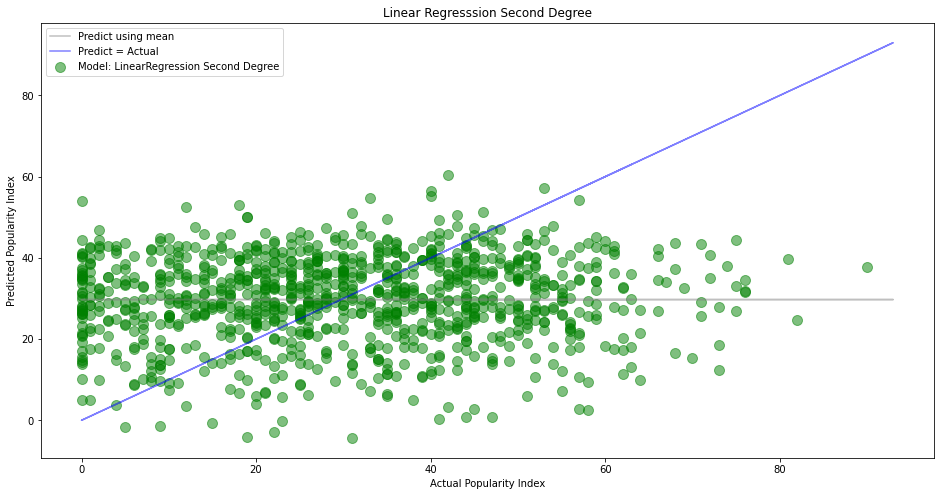

In [65]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.popularity, y_validate.popularity_pred_mean, alpha=.5, color="gray", label='Predict using mean')
plt.plot(y_validate.popularity, y_validate.popularity, alpha=.5, color="blue", label='Predict = Actual')
plt.scatter(y_validate.sample(1000).popularity, y_validate.sample(1000).popularity_pred_lm2, 
            alpha=.5, color="green", s=100, label="Model: LinearRegression Second Degree")
plt.legend()
plt.xlabel("Actual Popularity Index")
plt.ylabel("Predicted Popularity Index")
plt.title("Linear Regresssion Second Degree")
plt.show()

### Linear Regression Third Degree

In [66]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf.transform(X_validate)
X_test_degree3 =  pf.transform(X_test)

In [67]:
# create the model object
lm3 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm3.fit(X_train_degree3, y_train.popularity)

# predict train
y_train['popularity_pred_lm3'] = lm3.predict(X_train_degree3)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.popularity, y_train.popularity_pred_lm3) ** (1/2)

# predict validate
y_validate['popularity_pred_lm3'] = lm3.predict(X_validate_degree3)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.popularity, y_validate.popularity_pred_lm3) ** (1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  14.019995888651227 
Validation/Out-of-Sample:  14.061988411695049


In [68]:
metric_df = make_metric_df(y_validate.popularity, y_validate.popularity_pred_lm3,
               'Third degree linear regression',
               metric_df)
metric_df

model  RMSE_validate  r^2_validate
0                 median_baseline      17.776730      0.000000
1  OLS Regressor, Select Features      14.408118      0.341824
2                   lasso_alpha_1      17.759770      0.000000
3                             GLM      17.759770      0.000000
4                       quadratic      14.192520      0.361374
5  Third degree linear regression      14.061988      0.373068

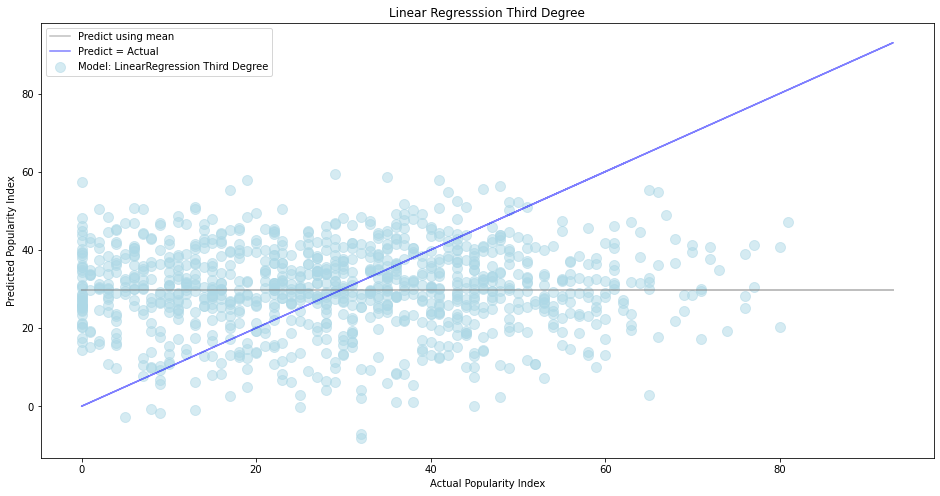

In [69]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.popularity, y_validate.popularity_pred_mean, alpha=.5, color="gray", label='Predict using mean')
plt.plot(y_validate.popularity, y_validate.popularity, alpha=.5, color="blue", label='Predict = Actual')
plt.scatter(y_validate.sample(1000).popularity, y_validate.sample(1000).popularity_pred_lm3, 
            alpha=.5, color="lightblue", s=100, label="Model: LinearRegression Third Degree")
plt.legend()
plt.xlabel("Actual Popularity Index")
plt.ylabel("Predicted Popularity Index")
plt.title("Linear Regresssion Third Degree")
plt.show()

### Linear Regression Fourth Degree

In [70]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=4)

# fit and transform X_train_scaled
X_train_degree4 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree4 = pf.transform(X_validate)
X_test_degree4 =  pf.transform(X_test)

In [71]:
# create the model object
lm4 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm4.fit(X_train_degree4, y_train.popularity)

# predict train
y_train['popularity_pred_lm4'] = lm4.predict(X_train_degree4)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.popularity, y_train.popularity_pred_lm4) ** (1/2)

# predict validate
y_validate['popularity_pred_lm4'] = lm4.predict(X_validate_degree4)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.popularity, y_validate.popularity_pred_lm4) ** (1/2)

print("RMSE for Polynomial Model, degrees=4\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=4
Training/In-Sample:  13.926766738432132 
Validation/Out-of-Sample:  14.015579281262967


In [72]:
metric_df = make_metric_df(y_validate.popularity, y_validate.popularity_pred_lm4,
               'Fourth degree linear regression',
               metric_df)
metric_df

model  RMSE_validate  r^2_validate
0                  median_baseline      17.776730      0.000000
1   OLS Regressor, Select Features      14.408118      0.341824
2                    lasso_alpha_1      17.759770      0.000000
3                              GLM      17.759770      0.000000
4                        quadratic      14.192520      0.361374
5   Third degree linear regression      14.061988      0.373068
6  Fourth degree linear regression      14.015579      0.377199

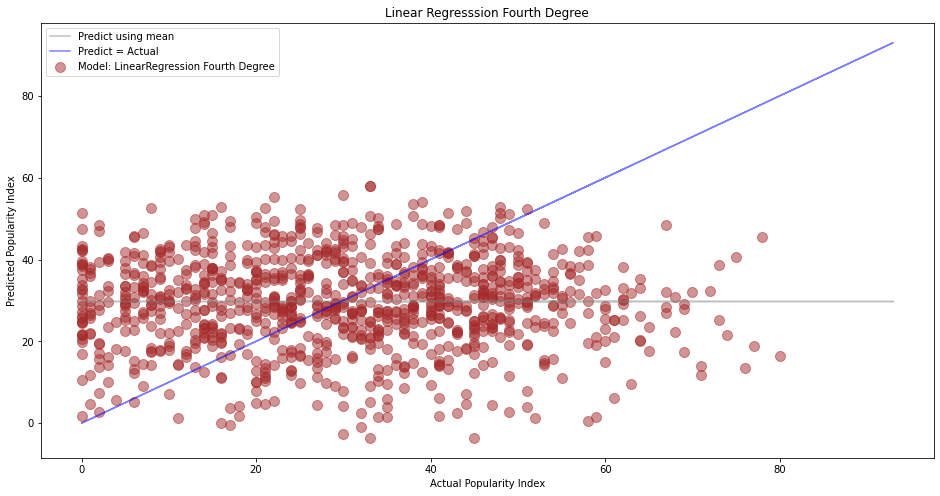

In [73]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.popularity, y_validate.popularity_pred_mean, alpha=.5, color="gray", label='Predict using mean')
plt.plot(y_validate.popularity, y_validate.popularity, alpha=.5, color="blue", label='Predict = Actual')
plt.scatter(y_validate.sample(1000).popularity, y_validate.sample(1000).popularity_pred_lm4, 
            alpha=.5, color="brown", s=100, label="Model: LinearRegression Fourth Degree")
plt.legend()
plt.xlabel("Actual Popularity Index")
plt.ylabel("Predicted Popularity Index")
plt.title("Linear Regresssion Fourth Degree")
plt.show()

### Linear Regression Fifth Degree

In [74]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=5)

# fit and transform X_train_scaled
X_train_degree5 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree5 = pf.transform(X_validate)
X_test_degree5 =  pf.transform(X_test)

In [75]:
# create the model object
lm5 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm5.fit(X_train_degree5, y_train.popularity)

# predict train
y_train['popularity_pred_lm5'] = lm5.predict(X_train_degree5)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.popularity, y_train.popularity_pred_lm5) ** (1/2)

# predict validate
y_validate['popularity_pred_lm5'] = lm5.predict(X_validate_degree5)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.popularity, y_validate.popularity_pred_lm5) ** (1/2)

print("RMSE for Polynomial Model, degrees=5\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=5
Training/In-Sample:  13.749886760476944 
Validation/Out-of-Sample:  14.098113993367313


In [76]:
metric_df = make_metric_df(y_validate.popularity, y_validate.popularity_pred_lm5,
               'Fifth degree linear regression',
               metric_df)
metric_df

model  RMSE_validate  r^2_validate
0                  median_baseline      17.776730      0.000000
1   OLS Regressor, Select Features      14.408118      0.341824
2                    lasso_alpha_1      17.759770      0.000000
3                              GLM      17.759770      0.000000
4                        quadratic      14.192520      0.361374
5   Third degree linear regression      14.061988      0.373068
6  Fourth degree linear regression      14.015579      0.377199
7   Fifth degree linear regression      14.098114      0.369842

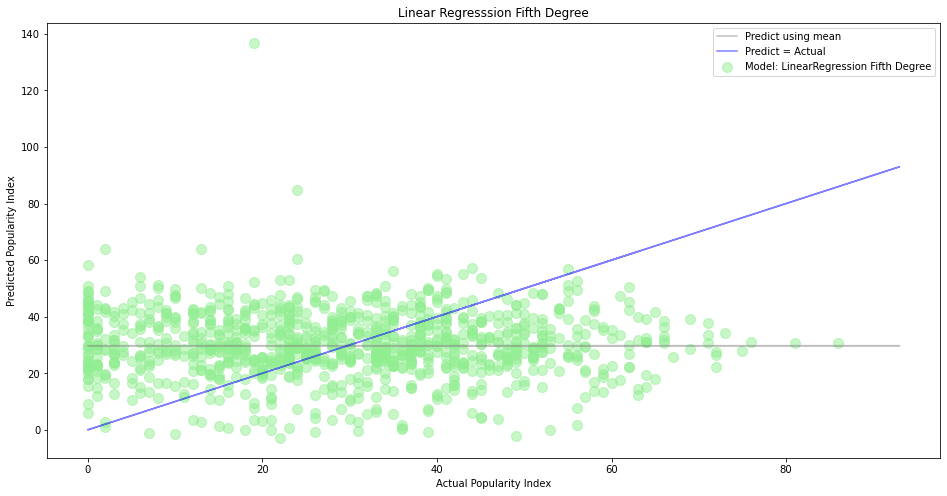

In [77]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.popularity, y_validate.popularity_pred_mean, alpha=.5, color="gray", label='Predict using mean')
plt.plot(y_validate.popularity, y_validate.popularity, alpha=.5, color="blue", label='Predict = Actual')
plt.scatter(y_validate.sample(1000).popularity, y_validate.sample(1000).popularity_pred_lm5, 
            alpha=.5, color="lightgreen", s=100, label="Model: LinearRegression Fifth Degree")
plt.legend()
plt.xlabel("Actual Popularity Index")
plt.ylabel("Predicted Popularity Index")
plt.title("Linear Regresssion Fifth Degree")
plt.show()

### Compare RMSE Values

In [78]:
metric_df = metric_df.sort_values(by = "RMSE_validate")

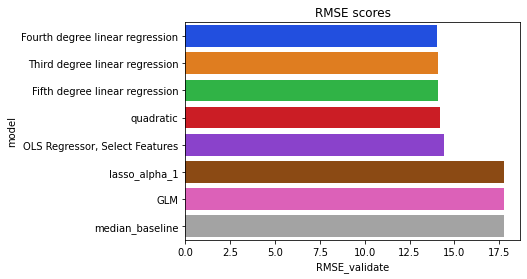

In [79]:
rmse_values = sns.barplot(x = metric_df.RMSE_validate, y= metric_df.model)
title = rmse_values.set(title = "RMSE scores")

The fourth degree linear regression model is our best model. This model performs better than the baseline, thus the fourth degree linear regression model is valid.

### Key Takeaway

 - Lasso Lars and Tweedie Regressor models barely outperformed the baseline model. The other models performed significantly better than baseline.
 - The Linear Regression Fourth Degree Model is the best. This model has the highest r^2 value and the lowest RMSE value. The Linear Regression Fourth Degree Model outperforms baseline, so it is valid.


### Which songs are most likely to be hits?

Out of curiosity, let's see what track this model predicted to be the most popular.

In [80]:
y_train.sort_values(by = "popularity_pred_lm4", ascending = False).head(3).index

Int64Index([97695, 53650, 118663], dtype='int64')

In [81]:
df.iloc[97695]

index                                                          158067
id                                             6wxZq37sANWYDJiDN5khyL
name                                                      Darte Remix
popularity                                                         70
duration_ms                                                    512060
explicit                                                            1
artists             ['Alex Rose', 'Casper Magico', 'Ñengo Flow', '...
id_artists          ['2DspEsT7UXGKd2VaaedgG4', '1fux65HMCBvfJHqlBc...
release_date                                               2018-07-27
danceability                                                    0.809
energy                                                          0.634
key                                                                 9
loudness                                                       -6.432
mode                                                                0
speechiness         

In [82]:
df.iloc[53650]

index                                    89661
id                      7tUXZgLbOCvRJ9FBlairoU
name                                     Venom
popularity                                  68
duration_ms                             134271
explicit                                     1
artists                         ['Ghostemane']
id_artists          ['3uL4UpqShC4p2x1dJutoRW']
release_date                        2016-07-03
danceability                             0.909
energy                                   0.573
key                                          5
loudness                                -6.856
mode                                         1
speechiness                              0.181
acousticness                            0.0332
instrumentalness                        0.0163
liveness                                 0.657
valence                                  0.392
tempo                                  144.946
time_signature                               4
year_of_relea

In [83]:
df.iloc[118663]

index                                   187969
id                      4GVIKZW6a4q0we4Ebc1FdP
name                            Big Fan Dulled
popularity                                  64
duration_ms                             160847
explicit                                     0
artists                  ['The Noise Project']
id_artists          ['3Q614JyDSProXXN4wXYYk1']
release_date                        2017-05-07
danceability                               0.0
energy                                  0.0354
key                                          2
loudness                               -47.731
mode                                         1
speechiness                                0.0
acousticness                              0.96
instrumentalness                       0.00868
liveness                                0.0923
valence                                    0.0
tempo                                      0.0
time_signature                               0
year_of_relea

In [84]:
y_validate.sort_values(by = "popularity_pred_lm4", ascending = False).head(3).index

Int64Index([2086, 326995, 307995], dtype='int64')

In [85]:
df.iloc[2086]

index                                     8105
id                      6lYqtOrLowtnslyKpyJQqe
name                   Till The Cows Come Home
popularity                                  36
duration_ms                             172973
explicit                                     1
artists                      ['Lucille Bogan']
id_artists          ['2cDKW2JF97WZ5ruG9Obfdf']
release_date                              1933
danceability                             0.682
energy                                   0.132
key                                          7
loudness                               -11.006
mode                                         1
speechiness                              0.121
acousticness                             0.987
instrumentalness                           0.0
liveness                                 0.185
valence                                  0.731
tempo                                  118.436
time_signature                               4
year_of_relea

In [86]:
df.iloc[326995]

index                                                          471029
id                                             4l53vqkvPJK8gbEPP5Jxsk
name                                                 Baby White Noise
popularity                                                         58
duration_ms                                                     83098
explicit                                                            0
artists             ['White Noise Radiance', 'White Noise Baby Sle...
id_artists          ['0QUBaF6Rtta4TTmxYYfzux', '4W12lEvVl5wectUtRN...
release_date                                               2019-07-05
danceability                                                      0.0
energy                                                        0.00002
key                                                                 1
loudness                                                       -9.923
mode                                                                1
speechiness         

In [87]:
df.iloc[307995]

index                                   444437
id                      3z3eMdRX4xR3vE5pnxaXx9
name                     Baby Sleep Pink Noise
popularity                                  52
duration_ms                              80000
explicit                                     0
artists                         ['littleONES']
id_artists          ['2p8rLc4EurmlEyJq770JPl']
release_date                        2019-11-27
danceability                               0.0
energy                                 0.00002
key                                          2
loudness                               -11.126
mode                                         1
speechiness                                0.0
acousticness                               0.0
instrumentalness                           0.0
liveness                                   0.0
valence                                    0.0
tempo                                      0.0
time_signature                               0
year_of_relea

**Note**

Interestingly, our model has predicted several relaxing background noise tracks as the tracks most likely to be popular. White noise appears to fit the criteria for a hit. One possible explanation is that chilled, ambient music is becoming more popular.  

## Out of Sample Evaluation

In [88]:
y_test.head()

popularity
49416            0
199305          28
188400          27
161999          32
383661          38

In [89]:
# predict on test
y_test['popularity_pred_lm4'] = lm4.predict(X_test_degree4)

In [90]:
# evaluate: rmse
rmse_test = mean_squared_error(y_test.popularity, y_test.popularity_pred_lm4)**(1/2)

print("RMSE for OLS Model using Fourth Degreee LinearRegression with Polynomial Regression\nOut-of-Sample Performance: ", rmse_test)

RMSE for OLS Model using Fourth Degreee LinearRegression with Polynomial Regression
Out-of-Sample Performance:  14.001583333490606


Our model outperforms baseline on the test dataset, so it has validity.

In [91]:
y_test.head()

popularity  popularity_pred_lm4
49416            0            37.225344
199305          28            32.216522
188400          27            27.361315
161999          32            21.492140
383661          38            46.167942

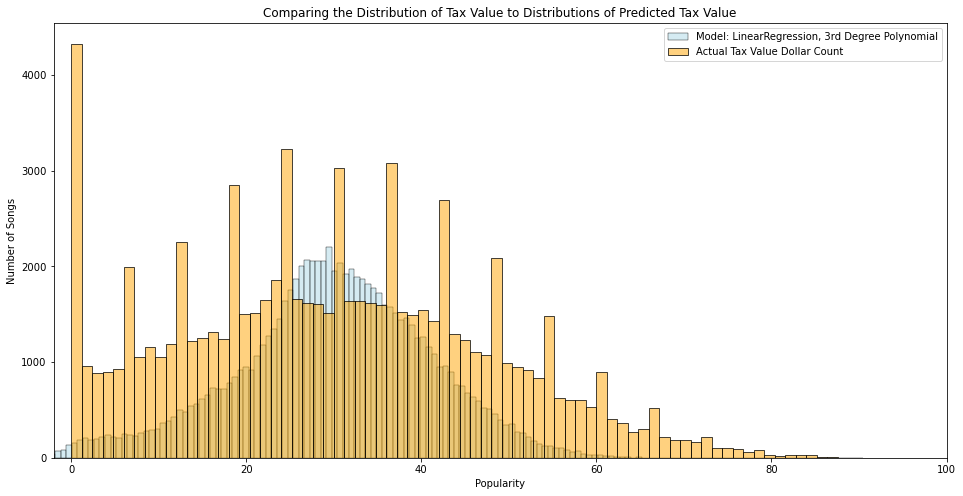

In [92]:
plt.figure(figsize=(16,8))
sns.histplot(y_test.popularity_pred_lm4, color='lightblue', alpha=.5, label="Model: LinearRegression, 3rd Degree Polynomial")
sns.histplot(y_test.popularity, color='orange', alpha=.5, label="Actual Tax Value Dollar Count")
plt.xlim(-2, 100)
plt.xlabel("Popularity")
plt.ylabel("Number of Songs")
plt.title("Comparing the Distribution of Tax Value to Distributions of Predicted Tax Value")
plt.legend()
plt.show()

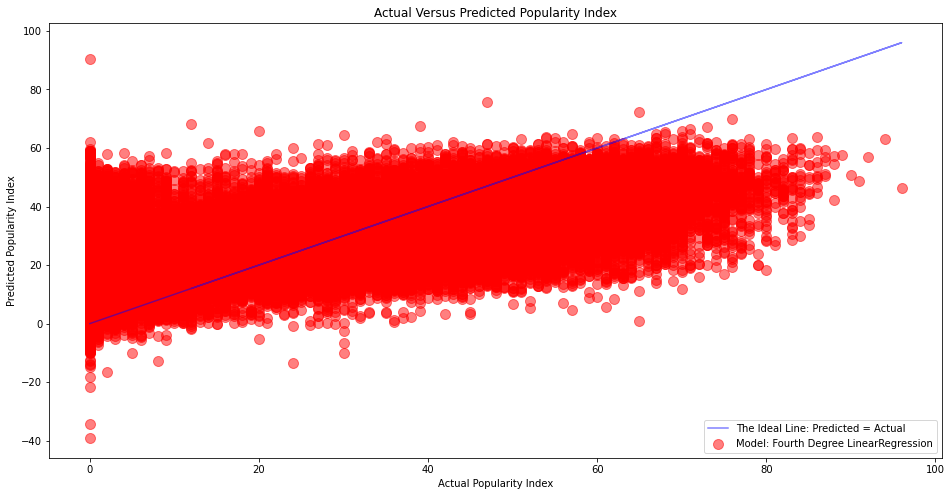

In [93]:
# y_validate.head()
plt.figure(figsize=(16,8))

plt.plot(y_test.popularity, y_test.popularity, alpha=.5, color="blue", label="The Ideal Line: Predicted = Actual")

plt.scatter(y_test.popularity, y_test.popularity_pred_lm4, 
            alpha=.5, color="red", s=100, label="Model: Fourth Degree LinearRegression")
plt.legend()
plt.xlabel("Actual Popularity Index")
plt.ylabel("Predicted Popularity Index")
plt.title("Actual Versus Predicted Popularity Index")
plt.show()

### Key Takeaway

 - We created a model, the Fourth Degree Linear Regression, that predicted on our test dataset significantly better than baseline.

## Conclusion

We were able to build a model which accurately predicted whether or not a song is likely to be a hit. For future exploration, I believe that we should investigate the following questions: 

 - Are there additional features we aren't measuring that could predict a track's popularity? For example, the fame level of the artist likely affects a song's popularity. 
 
 - Is there a more accurate, perhaps more complex, model that we can run on the data that we already have?
 
 - Is the data that we have accurate? As I mentioned earlier, many audiobooks have a high `danceability` score. I suspect that the tracks are ranked by machines, rather than manually. The system of how Spotify API assigns feature descriptions is worth looking into. 
 
 - How does song popularity differ by country or region? This data is for the entire world. What are the music popularity differences between nations, or even between different regions of the United States?
 
Finally, I am also interested to see how musical tastes have changed. This data is from six months ago. Have the musical tastes of the world changed in the past six months? 

## Bonus: Using Clustering to Categorize Music By Genre

We have already shown that we can use the features of music to predict the popularity of a song with reasonable accuracy. In this section of the project, I would like to show that we can also use clustering technology to group similar songs together by finding patterns in the data.

In [205]:
df.columns

Index(['id', 'name', 'popularity', 'duration_ms', 'explicit', 'artists',
       'id_artists', 'release_date', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature'],
      dtype='object')

In [206]:
X = train[['explicit',
'danceability',
'energy',
'mode',
'key',
'speechiness',
'acousticness',
'instrumentalness',
'liveness',
'tempo',
'time_signature',
'duration_ms_scaled',
'loudness_scaled',
'valence',
'year_of_release']]

We will use the elbow method to determine our optimum number of clusters. The elbow method means that we will use a line graph to visualize number of cluster vs. inertia. We will look for the "elbow" in the line graph, the part where intertia drops off significantly.



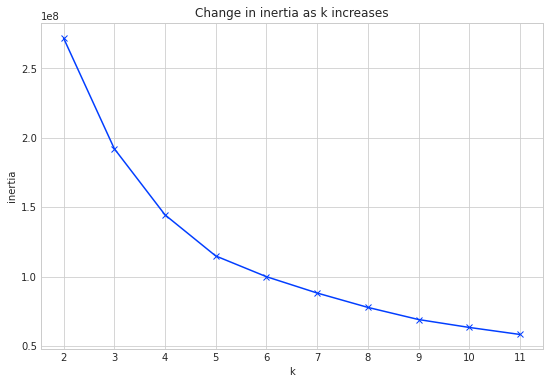

In [596]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [597]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(X)

kmeans.predict(X)

array([5, 5, 0, ..., 1, 0, 2], dtype=int32)

In [598]:
train['cluster'] = kmeans.predict(X)

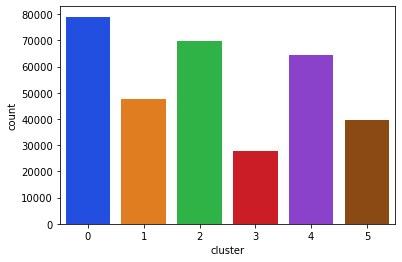

In [599]:
counts_by_cluster = sns.countplot(x = train.cluster)

In [600]:
train.head(10)

id                            name  popularity  \
404070  4RoQxXt8eSKeSFmhxLXu3x                       Oru Ooril          39   
319183  6FxUiq2HJbjyj4dBnXumrb  Lay down (Candles in the rain)           7   
545921  3GcY5WwLab9cMJimIIqSh1                         Playful          28   
113274  0EvOQBSyW3uSfwpcaj5xLe            Time - 2013 Remaster          11   
112835  4i3ilJFJbMwLLK3g0ECkXp           Jy Soen Soos 'n Engel          22   
243942  1sapJ0ghCrB804CK2SQoLl                Океан и три реки          47   
247901  7H9hrwz5IBDcHeHflB7dZh             Ya No Me Arrepiento          19   
370623  4v3AuNSbedru7LpWlpg1Mp                      Zor Yıllar          36   
145553  47YmRDI67DigzJtlcg0BGK           Sigo Buscando Un Amor          12   
545576  1qBycURgOlsk4UtBsSY8XV                 Lendaval Vaibal          16   

        duration_ms  explicit  \
404070       279467         0   
319183       274274         0   
545921       167413         0   
113274       315855         0   
112835       228653         0   
243942       218867         0   
247901       247693         0   
370623       206053         0   
145553       409133         0   
545576       266573         0   

                                                  artists  \
404070                                        ['Karthik']   
319183                               ['Emilíana Torrini']   
545921                                 ['Frankie Animal']   
113274                                    ['David Bowie']   
112835                                   ['David Fourie']   
243942                                 ['Valery Meladze']   
247901                                   ['Sergio Denis']   
370623  ['Kemal Sahir Gürel', 'Erdal Güney', 'Hüseyin ...   
145553                                  ['Roberto Roena']   
545576                                        ['Smilers']   

                                               id_artists release_date  \
404070                         ['0LSPREIgGMZXCuKVel7LVD']   2003-09-27   
319183                         ['08j69Ndyx1P7RLO3Janb5P']   1996-01-01   
545921                         ['1YYYGhGZWuWjLTpxdggqpO']   2019-06-07   
113274                         ['0oSGxfWSnnOXhD2fKuz2Gy']   2015-09-25   
112835                         ['3372wrCwHX44K1vjwiZHoA']   2011-04-04   
243942                         ['2igtm1MhKEpmG3PzToJT40']   2003-01-01   
247901                         ['6J19N5JZkGRjuONpiizCIe']   1971-01-01   
370623  ['1WeO0UYvbcLvA27hupeCYV', '77PSs92ix6empuwnNu...   2007-01-03   
145553                         ['4i5rDrP2IqCdMgde0vIpyB']   1980-12-31   
545576                         ['3gDHpjemovd3LuV3tHgjOq']   2014-04-16   

        danceability  energy  ...  acousticness  instrumentalness  liveness  \
404070         0.594   0.633  ...      0.281000          0.000000    0.0559   
319183         0.305   0.726  ...      0.183000          0.000000    0.1340   
545921         0.595   0.594  ...      0.040500          0.000066    0.1340   
113274         0.330   0.652  ...      0.192000          0.000003    0.1050   
112835         0.601   0.953  ...      0.000192          0.000000    0.0971   
243942         0.606   0.864  ...      0.120000          0.000000    0.3880   
247901         0.430   0.304  ...      0.877000          0.000004    0.2170   
370623         0.289   0.414  ...      0.894000          0.000008    0.2240   
145553         0.536   0.613  ...      0.551000          0.007360    0.1290   
545576         0.665   0.869  ...      0.059800          0.000000    0.5770   

        valence    tempo  time_signature  year_of_release  duration_ms_scaled  \
404070    0.757  169.779               4             2003            0.051132   
319183    0.592  167.728               4             1996            0.050171   
545921    0.566   90.053               4             2019            0.030382   
113274    0.369  145.186               4             2015            0.057871   
112835    0.731  125.964               4   

We now have six groups of similar sounding songs.

### Group 0

In [603]:
train_0 = train[train.cluster == 0]

In [604]:
train_0.head()

id                                name  \
545921  3GcY5WwLab9cMJimIIqSh1                             Playful   
243942  1sapJ0ghCrB804CK2SQoLl                    Океан и три реки   
370623  4v3AuNSbedru7LpWlpg1Mp                          Zor Yıllar   
545576  1qBycURgOlsk4UtBsSY8XV                     Lendaval Vaibal   
415692  5IgHqf44izKwUGgP5dGVlO  Sleep Tight (Instrumental Version)   

        popularity  duration_ms  explicit  \
545921          28       167413         0   
243942          47       218867         0   
370623          36       206053         0   
545576          16       266573         0   
415692          57        74859         0   

                                                  artists  \
545921                                 ['Frankie Animal']   
243942                                 ['Valery Meladze']   
370623  ['Kemal Sahir Gürel', 'Erdal Güney', 'Hüseyin ...   
545576                                        ['Smilers']   
415692                             ['Nursery Rhymes 123']   

                                               id_artists release_date  \
545921                         ['1YYYGhGZWuWjLTpxdggqpO']   2019-06-07   
243942                         ['2igtm1MhKEpmG3PzToJT40']   2003-01-01   
370623  ['1WeO0UYvbcLvA27hupeCYV', '77PSs92ix6empuwnNu...   2007-01-03   
545576                         ['3gDHpjemovd3LuV3tHgjOq']   2014-04-16   
415692                         ['47tuSUJMhsa3twW6wgKdIW']   2016-01-26   

        danceability   energy  ...  acousticness  instrumentalness  liveness  \
545921         0.595  0.59400  ...        0.0405          0.000066     0.134   
243942         0.606  0.86400  ...        0.1200          0.000000     0.388   
370623         0.289  0.41400  ...        0.8940          0.000008     0.224   
545576         0.665  0.86900  ...        0.0598          0.000000     0.577   
415692         0.833  0.00417  ...        0.9790          0.012900     0.137   

        valence   tempo  time_signature  year_of_release  duration_ms_scaled  \
545921    0.566  90.053               4             2019            0.030382   
243942    0.724  95.012               4             2003            0.039911   
370623    0.527  78.625               3             2007            0.037538   
545576    0.773  99.533               4             2014            0.048745   
415692    0.918  89.900               3             2016            0.013243   

        loudness_scaled  cluster  
545921         0.781858        0  
243942         0.841911        0  
370623         0.817337        0  
545576         0.864105        0  
415692         0.541139        0  

[5 rows x 24 columns]

Group 0 seems to be mostly upbeat songs with an electronic sound.

### Group 1

In [605]:
train_1 = train[train.cluster == 1]

In [607]:
train_1.head()

id  \
247901  7H9hrwz5IBDcHeHflB7dZh   
305610  01tdB0wTXWY4ue7GAySlWl   
44075   3OWfEECAO2MXsUH5u7J4bE   
337889  5X5YjQO3OqHeAJzpQARMDB   
240147  3D4xY8ldSzNHDMP4Zynady   

                                                    name  popularity  \
247901                               Ya No Me Arrepiento          19   
305610               I've Got It Bad And That Ain T Good          11   
44075                                   Get Back In Line          40   
337889  Hallelujah Chorus - From the Oratorio, "Messiah"          12   
240147                                            Amparo          32   

        duration_ms  explicit                   artists  \
247901       247693         0          ['Sergio Denis']   
305610       372747         0   ['Red Garland Quintet']   
44075        184160         0             ['The Kinks']   
337889       245280         0         ['Johnny Mathis']   
240147       219693         0  ['Antônio Carlos Jobim']   

                        id_artists release_date  danceability  energy  ...  \
247901  ['6J19N5JZkGRjuONpiizCIe']   1971-01-01         0.430  0.3040  ...   
305610  ['0JsWkl2GlMvsvCQzYUQQ97']   1957-01-01         0.545  0.1710  ...   
44075   ['1SQRv42e4PjEYfPhS0Tk9E']   1970-11-27         0.323  0.5540  ...   
337889  ['21LGsW7bziR4Ledx7WZ1Wf']   1963-10-04         0.404  0.3500  ...   
240147  ['3pO5VjZ4wOHCMBXOvbMISG']   1970-01-01         0.225  0.0763  ...   

        acousticness  instrumentalness  liveness  valence   tempo  \
247901         0.877          0.000004    0.2170   0.2420  77.332   
305610         0.965          0.921000    0.0976   0.1450  62.303   
44075          0.142          0.000044    0.2120   0.4200  93.428   
337889         0.889          0.000215    0.2290   0.4670  96.672   
240147         0.982          0.887000    0.1280   0.0378  82.881   

        time_signature  year_of_release  duration_ms_scaled  loudness_scaled  \
247901               4             1971            0.045249         0.750726   
305610               4             1957            0.068406         0.722634   
44075                4             1970            0.033483         0.800826   
337889               4             1963            0.044802         0.772044   
240147               4             1970            0.040063         0.593006   

        cluster  
247901        1  
305610        1  
44075         1  
337889        1  
240147        1  

[5 rows x 24 columns]

Group 1 is more melancholic, slower songs.

### Group 2

In [609]:
train_2 = train[train.cluster == 2]

In [611]:
train_2.head()

id                   name  popularity  \
113274  0EvOQBSyW3uSfwpcaj5xLe   Time - 2013 Remaster          11   
112835  4i3ilJFJbMwLLK3g0ECkXp  Jy Soen Soos 'n Engel          22   
284313  27CunNfh9sPzaNhRirLPjA         Fortunate Fool          38   
262296  2g7ZMGF9V9vuky7fYb2NVZ            Čert a Kača          17   
371127  3VYxTZHWMcuzSSgR03msGs                   Eski          41   

        duration_ms  explicit  \
113274       315855         0   
112835       228653         0   
284313       228653         0   
262296       901680         0   
371127       302138         0   

                                                  artists  \
113274                                    ['David Bowie']   
112835                                   ['David Fourie']   
284313                                   ['Jack Johnson']   
262296  ['Marián Labuda', 'R.Mihina', 'M.Matejka', 'V....   
371127                                   ['Şebnem Ferah']   

                                               id_artists release_date  \
113274                         ['0oSGxfWSnnOXhD2fKuz2Gy']   2015-09-25   
112835                         ['3372wrCwHX44K1vjwiZHoA']   2011-04-04   
284313                         ['3GBPw9NK25X1Wt2OUvOwY3']   2001-02-01   
262296  ['1mHKvmQJOQVhd1nLEkiAZr', '6FDvKh65apZwn8Xr0S...   2002-03-07   
371127                         ['74xBVPWYoSf5pvo5IkePRO']   2009-12-19   

        danceability  energy  ...  acousticness  instrumentalness  liveness  \
113274         0.330   0.652  ...      0.192000          0.000003    0.1050   
112835         0.601   0.953  ...      0.000192          0.000000    0.0971   
284313         0.772   0.284  ...      0.542000          0.001720    0.1090   
262296         0.714   0.437  ...      0.826000          0.000000    0.0655   
371127         0.552   0.675  ...      0.333000          0.000000    0.1070   

        valence    tempo  time_signature  year_of_release  duration_ms_scaled  \
113274    0.369  145.186               4             2015            0.057871   
112835    0.731  125.964               4             2011            0.041723   
284313    0.328  129.326               4             2001            0.041723   
262296    0.487  119.787               4             2002            0.166354   
371127    0.317  125.898               4             2009            0.055331   

        loudness_scaled  cluster  
113274         0.787433        2  
112835         0.834877        2  
284313         0.766453        2  
262296         0.740405        2  
371127         0.860680        2  

[5 rows x 24 columns]

Group 2 has an acoustic rock-and-roll quality.

### Group 3

In [613]:
train_3 = train[train.cluster == 3]

In [614]:
train_3.head()

id                         name  popularity  \
267026  0St7qoRogQ9B9uIqmLdjIr                     Red Clay          20   
189759  5oD4obArjBOP28YjclhcNr  O Astronauta - Instrumental          19   
2186    1P3YFEDFTCSSQ4KVoUgO7t              Smashin' Thirds           4   
136319  7nKfyxYFXf5HdwSbeLFq1l               Blueberry Hill           0   
514476  08CkhcDtEogvbDzCIOBivc                   Summertime           0   

        duration_ms  explicit                                artists  \
267026       728533         0                    ['Freddie Hubbard']   
189759       181613         0  ['Odette Lara', 'Vinícius de Moraes']   
2186         184920         0                        ['Fats Waller']   
136319       199101         0                        ['Russ Morgan']   
514476       201520         0                                   ['']   

                                               id_artists release_date  \
267026                         ['0fTHKjepK5HWOrb2rkS5Em']   1970-01-01   
189759  ['1qCTWVxt74ULl0u12pjnTc', '5HlnN6xF2MD87KhGRm...   1963-01-01   
2186                           ['0DYWCXTkNqGFZIf67SrWEa']   1926-01-01   
136319                         ['4p2WNjwHrHBUD9XJBmbf7H']   1944-01-01   
514476                         ['0LyfQWJT6nXafLPZqxe9Of']   1950-09-01   

        danceability  energy  ...  acousticness  instrumentalness  liveness  \
267026         0.530   0.388  ...         0.338          0.261000    0.0958   
189759         0.423   0.479  ...         0.186          0.000002    0.2550   
2186           0.541   0.247  ...         0.982          0.868000    0.1310   
136319         0.313   0.218  ...         0.799          0.006770    0.1280   
514476         0.268   0.322  ...         0.988          0.288000    0.6020   

        valence    tempo  time_signature  year_of_release  duration_ms_scaled  \
267026    0.587  139.339               4             1970            0.134290   
189759    0.591  153.212               4             1963            0.033012   
2186      0.812  111.664               4             1926            0.033624   
136319    0.316  115.668               4             1944            0.036250   
514476    0.319  146.201               4             1950            0.036698   

        loudness_scaled  cluster  
267026         0.715999        3  
189759         0.736872        3  
2186           0.625244        3  
136319         0.739790        3  
514476         0.711699        3  

[5 rows x 24 columns]

Group 3 has an instrumental, jazzy, old-time feel.

### Group 4

In [624]:
train_4 = train[train.cluster == 4]

In [625]:
train_4.head()

id                   name  popularity  \
145553  47YmRDI67DigzJtlcg0BGK  Sigo Buscando Un Amor          12   
452182  1i1SZziMzvtv49MXiJKmcv             Evangelina          19   
207534  4AOQOmkh8YT3HA8e0xBw76              Cervecita          16   
167720  54toym5sP7H1vi8NxMTlFH       Desperate Dreams          37   
377606  6yPVqp3Nt2mFzvdExaIWP9            J'attendrai          33   

        duration_ms  explicit               artists  \
145553       409133         0     ['Roberto Roena']   
452182       225253         0  ['Jonathan Edwards']   
207534       166547         0        ['Los Shapis']   
167720       286933         0          ['Survivor']   
377606       177973         0   ['Claude François']   

                        id_artists release_date  danceability  energy  ...  \
145553  ['4i5rDrP2IqCdMgde0vIpyB']   1980-12-31         0.536   0.613  ...   
452182  ['7gyVuJLsatWofXCAw1SGxM']   1977-01-01         0.640   0.325  ...   
207534  ['3LorjMdYWKEtf3wdNtjM6v']   1995-08-08         0.594   0.685  ...   
167720  ['26bcq2nyj5GB7uRr558iQg']   1988-09-25         0.625   0.646  ...   
377606  ['0P2p1bqVyP2EgqubwjTBUJ']   1993-01-01         0.521   0.587  ...   

        acousticness  instrumentalness  liveness  valence    tempo  \
145553        0.5510          0.007360     0.129    0.798  104.461   
452182        0.4410          0.293000     0.150    0.765  132.707   
207534        0.7190          0.000082     0.224    0.892  113.193   
167720        0.0691          0.000035     0.114    0.362  121.647   
377606        0.2850          0.000000     0.114    0.619  123.587   

        time_signature  year_of_release  duration_ms_scaled  loudness_scaled  \
145553               4             1980            0.075144         0.816369   
452182               4             1977            0.041093         0.679553   
207534               4             1995            0.030222         0.847195   
167720               4             1988            0.052515         0.754704   
377606               4             1993            0.032338         0.852325   

        cluster  
145553        4  
452182        4  
207534        4  
167720        4  
377606        4  

[5 rows x 24 columns]

Group 4 has a traditional Latin/country sound.

### Group 5

In [621]:
train_5 = train[train.cluster == 5]

In [622]:
train_5.head()

id                            name  popularity  \
404070  4RoQxXt8eSKeSFmhxLXu3x                       Oru Ooril          39   
319183  6FxUiq2HJbjyj4dBnXumrb  Lay down (Candles in the rain)           7   
275579  4B58w2sCk7y7mcIdIoP7Gd              Especially for You          54   
301637  2QQ0lfEAu3ncUHM3C6Rkg3                Is Anybody Home?          45   
557744  27K9pfqACmZxsvNpJ8FSxq                Return to Myself          40   

        duration_ms  explicit               artists  \
404070       279467         0           ['Karthik']   
319183       274274         0  ['Emilíana Torrini']   
275579       223013         0              ['MYMP']   
301637       218000         0    ['Our Lady Peace']   
557744       269110         0       ['Mari Hamada']   

                        id_artists release_date  danceability  energy  ...  \
404070  ['0LSPREIgGMZXCuKVel7LVD']   2003-09-27         0.594   0.633  ...   
319183  ['08j69Ndyx1P7RLO3Janb5P']   1996-01-01         0.305   0.726  ...   
275579  ['5elcNQkZ6FCZA3grSOMngY']   2005-03-10         0.698   0.398  ...   
301637  ['1lqW59DUEKqvcHc8mVWBtH']   1999-09-06         0.442   0.896  ...   
557744  ['2lQwmHGmTnEu1jjfAgUAcq']   2008-10-22         0.390   0.922  ...   

        acousticness  instrumentalness  liveness  valence    tempo  \
404070        0.2810               0.0    0.0559    0.757  169.779   
319183        0.1830               0.0    0.1340    0.592  167.728   
275579        0.4990               0.0    0.1800    0.758  163.028   
301637        0.0219               0.0    0.3830    0.573  155.044   
557744        0.0770               0.0    0.0674    0.560  167.729   

        time_signature  year_of_release  duration_ms_scaled  loudness_scaled  \
404070               4             2003            0.051132         0.818305   
319183               4             1996            0.050171         0.809412   
275579               4             2005            0.040678         0.784838   
301637               4             1999            0.039750         0.850635   
557744               4             2008            0.049215         0.880047   

        cluster  
404070        5  
319183        5  
275579        5  
301637        5  
557744        5  

[5 rows x 24 columns]

Group 5 has an uplifting, energetic, gospel-like quality. 

### Key Takeaway

 - Our model split the tracks into six "genres", each with a distinctive sound. 
 - A topic for further exploration would be to see how using a different amount of clusters affects musical groupings.